# Time series forecasting fundamentals with TensorFlow 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

## Get data



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-09-06 09:20:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2023-09-06 09:20:24 (13.4 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [ ]:
# Import with pandas
import pandas as pd

# Let's read in Bitcoin data and parse the data
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=['Date'],
                 index_col=['Date']) #parse the date column and tell pandas column 1 is a datetime
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8years but there's 2787 samples.


Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> **🔑Note**: The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


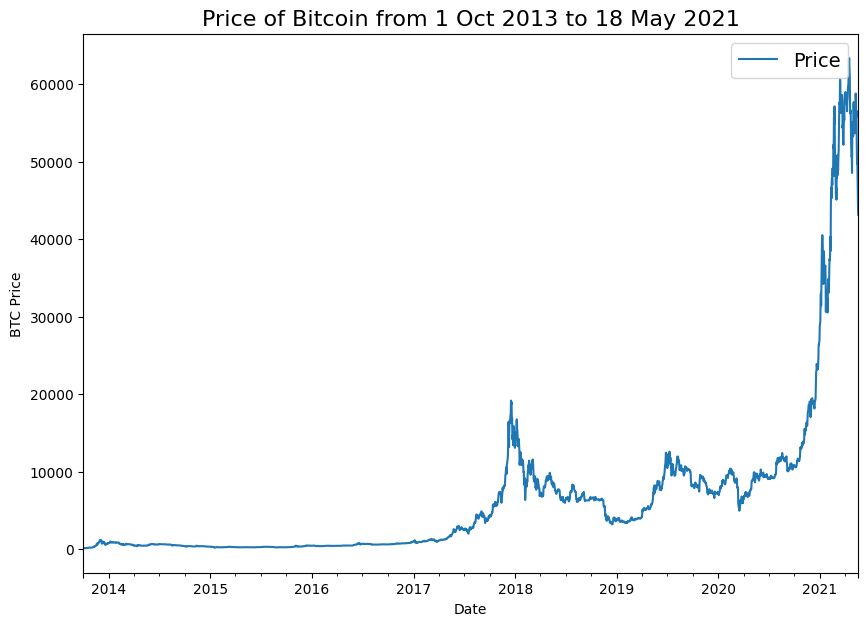

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) #get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View_first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

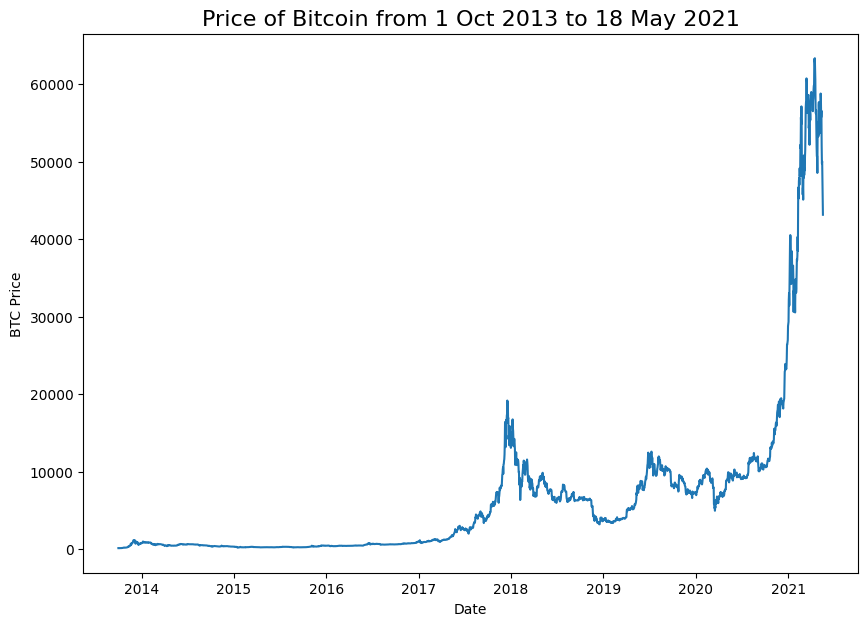

In [ ]:
# Plot from csv
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16);

## Format data part 1: Create train and test sets of time series data

### Creating train and test sets with time series data(the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10],prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, #dates
                                                    prices,# BTC_prices
                                                    test_size=0.2,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

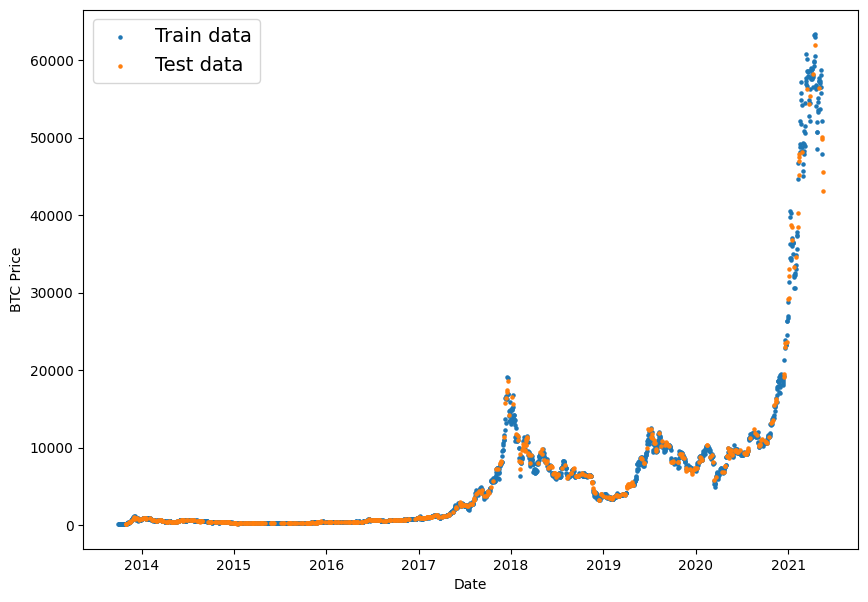

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series(the right way)

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) #80% train, 20%test - u can change these values as needed, e.g. 90/10

# Create train data splits(everything before split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits(everything after split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

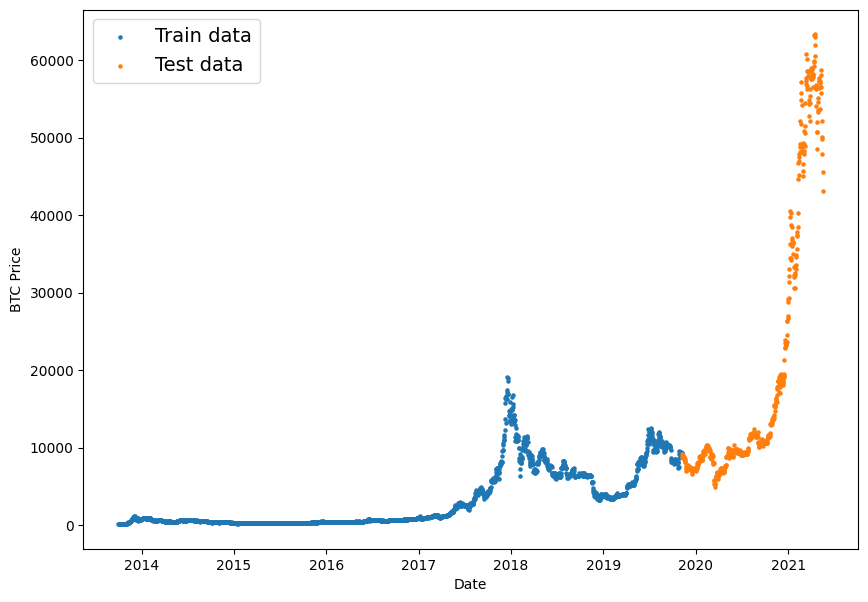

In [ ]:
# Let's plot right train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Creating a plotting function
Typing a plotting function is tedious, let's functionize it

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot (setting a value index from start of timesteps)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # PLot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) #make label bigger
  plt.grid(True)



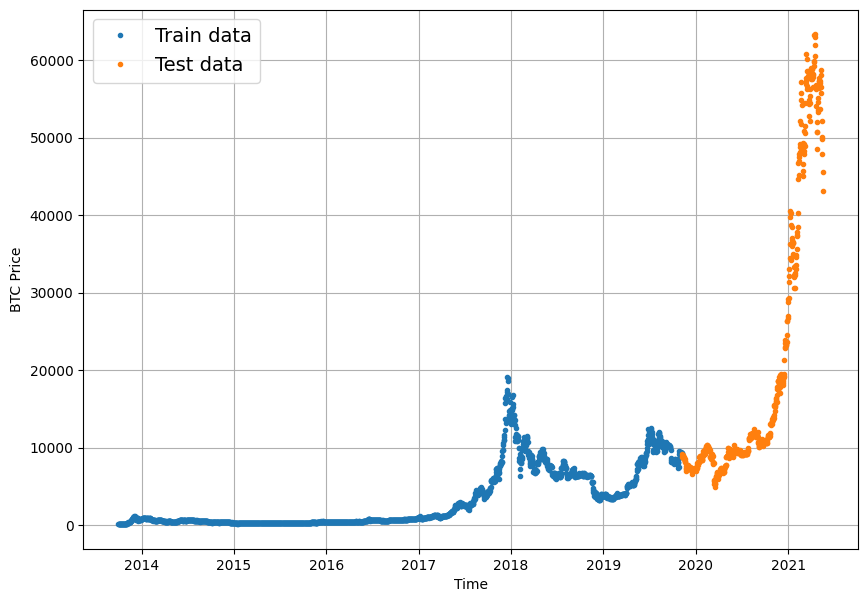

In [ ]:
# Test plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")


## Modelling Experiments

We've got some of the Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window=7
* 2 Same as 1, horizon = 1, window=30
* 3 Same as 1, horizon = 7, window=30
* 4 Conv1D  
* 5 LSTM
* 6 Same as 1(but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timesteps t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

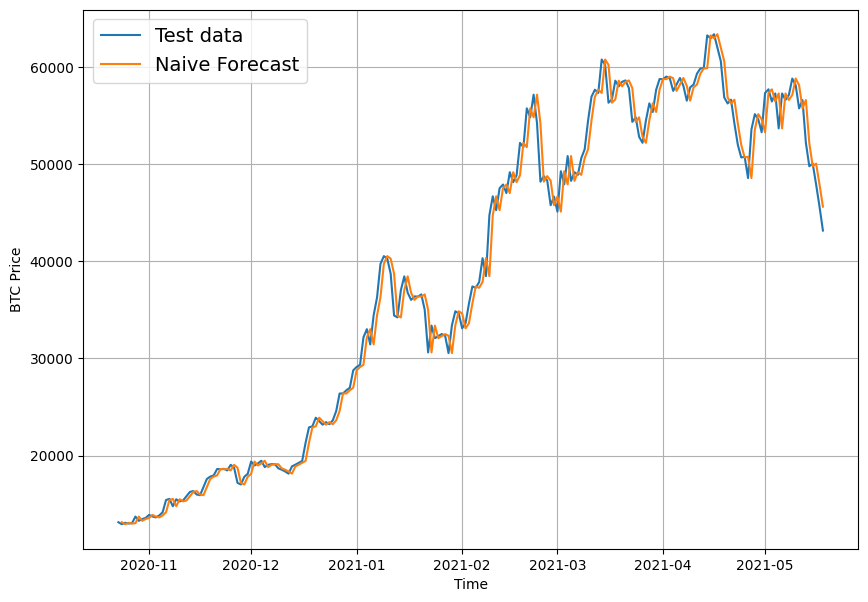

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10,7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350,format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast,start=350, format="-", label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

we're predicting a number, so that means we have a form of regression problem.

Because we're working on a regrression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean absolute error
* MSE - Mean squared error
* RMSE - Root mean squared error
* MAPE/sMAPE - (symmetric) Mean absolute percentage error
* MASE -  Scaled Mean absolute error

For all the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts(y_pred) compare against the actual values (y_true or ground truth values)?**

In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) #seasonality is 1 day.. hence shift of 1

  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype(for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred , dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae":mae.numpy(),
           "mape": mape.numpy(),
          "mase": mase.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
         }

In [ ]:
naive_results = evaluate_preds(y_true= y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Format Data Part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
# What we want to do with the Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to  make the prediction

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g.[0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7 ,8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows` function we created above to turn the window steps into windows with a specified horizon



In [ ]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T #Create a 2D array of windowa of size window_size

  # 3. Index on the target array(a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels


In [ ]:
full_windows, full_labels= make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


### Turning windows into train and test sets

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels in train and test splits.
  """
  split_size = int((len(windows)) * (1- test_split)) #this will default to 80% train 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:3],train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116]]))

In [ ]:
y_train

array([ 123.65499   ,  125.455     ,  108.58483   , ..., 9369.62808116,
       9326.59962378, 9335.75240233])

In [ ]:
# check to see if train labels are the same(before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

### Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.



In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name ),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window= 7, horizon= 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")# linear activation is the same as having no activation
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer="adam",
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data= (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 2156.2830 - mae: 2156.2830 - mse: 12760257.0000  

18/18 [==============================] - 6s 47ms/step - loss: 2048.3076 - mae: 2048.3076 - mse: 11887793.0000 - val_loss: 2737.3252 - val_mae: 2737.3252 - val_mse: 16022443.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 317.2354 - mae: 317.2354 - mse: 427158.9688

18/18 [==============================] - 1s 29ms/step - loss: 329.5492 - mae: 329.5492 - mse: 425607.4062 - val_loss: 1318.4109 - val_mae: 1318.4109 - val_mse: 4862850.5000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 166.2434 - mae: 166.2434 - mse: 111280.3281

18/18 [==============================] - 1s 29ms/step - loss: 230.4526 - mae: 230.4526 - mse: 254204.1719 - val_loss: 1114.6777 - val_mae: 1114.6777 - val_mse: 4143430.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 266.9992 - mae: 266.9992 - mse: 365584.9375

18/18 [==============================] - 1s 29ms/step - loss: 200.4780 - mae: 200.4780 - mse: 208527.2969 - val_loss: 1094.4791 - val_mae: 1094.4791 - val_mse: 4000730.2500
Epoch 5/100
15/18 [========================>.....] - ETA: 0s - loss: 200.8760 - mae: 200.8760 - mse: 210653.7656

18/18 [==============================] - 1s 32ms/step - loss: 195.4136 - mae: 195.4136 - mse: 198899.0312 - val_loss: 1084.0890 - val_mae: 1084.0890 - val_mse: 3842172.0000
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 194.8171 - mae: 194.8171 - mse: 197053.2344

18/18 [==============================] - 1s 30ms/step - loss: 194.8171 - mae: 194.8171 - mse: 197053.2344 - val_loss: 1077.1371 - val_mae: 1077.1371 - val_mse: 3886871.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 236.1770 - mae: 236.1770 - mse: 378302.7500

18/18 [==============================] - 1s 43ms/step - loss: 193.2640 - mae: 193.2640 - mse: 195076.6875 - val_loss: 1044.8912 - val_mae: 1044.8912 - val_mse: 3657694.5000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 169.9721 - mae: 169.9721 - mse: 108469.0781

18/18 [==============================] - 1s 30ms/step - loss: 185.5916 - mae: 185.5916 - mse: 181944.3125 - val_loss: 1034.2155 - val_mae: 1034.2155 - val_mse: 3458093.7500
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 179.6356 - mae: 179.6356 - mse: 171995.8438 - val_loss: 1040.3723 - val_mae: 1040.3723 - val_mse: 3355595.5000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 194.8724 - mae: 194.8724 - mse: 263128.7500

18/18 [==============================] - 0s 29ms/step - loss: 175.4671 - mae: 175.4671 - mse: 164840.8281 - val_loss: 962.3065 - val_mae: 962.3065 - val_mse: 3050413.0000
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 169.4346 - mae: 169.4346 - mse: 156363.0312

18/18 [==============================] - 1s 32ms/step - loss: 168.2882 - mae: 168.2882 - mse: 152357.0469 - val_loss: 920.4076 - val_mae: 920.4076 - val_mse: 2814092.5000
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 163.3647 - mae: 163.3647 - mse: 144007.9844 - val_loss: 1006.2233 - val_mae: 1006.2233 - val_mse: 2944029.5000
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 131.0431 - mae: 131.0431 - mse: 111085.5859

18/18 [==============================] - 1s 36ms/step - loss: 161.1689 - mae: 161.1689 - mse: 142020.8438 - val_loss: 881.4386 - val_mae: 881.4386 - val_mse: 2550761.0000
Epoch 14/100
14/18 [======================>.......] - ETA: 0s - loss: 156.2507 - mae: 156.2507 - mse: 135652.0781

18/18 [==============================] - 1s 44ms/step - loss: 154.6417 - mae: 154.6417 - mse: 132263.1719 - val_loss: 880.1953 - val_mae: 880.1953 - val_mse: 2468436.5000
Epoch 15/100
18/18 [==============================] - 0s 7ms/step - loss: 155.2545 - mae: 155.2545 - mse: 131633.5000 - val_loss: 921.8422 - val_mae: 921.8422 - val_mse: 2526112.7500
Epoch 16/100
13/18 [====================>.........] - ETA: 0s - loss: 152.2364 - mae: 152.2364 - mse: 119886.9062

18/18 [==============================] - 1s 34ms/step - loss: 149.9273 - mae: 149.9273 - mse: 124833.1328 - val_loss: 833.8779 - val_mae: 833.8779 - val_mse: 2245582.5000
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 142.8271 - mae: 142.8271 - mse: 106247.3672

18/18 [==============================] - 1s 31ms/step - loss: 147.0767 - mae: 147.0767 - mse: 119597.1406 - val_loss: 816.7778 - val_mae: 816.7778 - val_mse: 2158418.0000
Epoch 18/100
15/18 [========================>.....] - ETA: 0s - loss: 149.7872 - mae: 149.7872 - mse: 122396.2812

18/18 [==============================] - 1s 32ms/step - loss: 143.8176 - mae: 143.8176 - mse: 115651.3438 - val_loss: 806.2740 - val_mae: 806.2740 - val_mse: 2085094.6250
Epoch 19/100
17/18 [===========================>..] - ETA: 0s - loss: 141.0749 - mae: 141.0749 - mse: 111780.2500

18/18 [==============================] - 1s 31ms/step - loss: 140.2978 - mae: 140.2978 - mse: 111233.6562 - val_loss: 784.2392 - val_mae: 784.2392 - val_mse: 1999090.3750
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 147.3782 - mae: 147.3782 - mse: 126063.1016

18/18 [==============================] - 1s 30ms/step - loss: 139.6266 - mae: 139.6266 - mse: 110726.4844 - val_loss: 778.9035 - val_mae: 778.9035 - val_mse: 2032690.3750
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 182.7613 - mae: 182.7613 - mse: 150529.4688

18/18 [==============================] - 1s 30ms/step - loss: 138.7864 - mae: 138.7864 - mse: 108591.2266 - val_loss: 749.4357 - val_mae: 749.4357 - val_mse: 1888079.6250
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 135.8882 - mae: 135.8882 - mse: 104413.6797

18/18 [==============================] - 1s 30ms/step - loss: 135.8882 - mae: 135.8882 - mse: 104413.6797 - val_loss: 737.2191 - val_mae: 737.2191 - val_mse: 1803482.6250
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 140.5815 - mae: 140.5815 - mse: 91093.4922

18/18 [==============================] - 1s 30ms/step - loss: 131.8463 - mae: 131.8463 - mse: 99409.0234 - val_loss: 725.7098 - val_mae: 725.7098 - val_mse: 1751598.6250
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 148.8808 - mae: 148.8808 - mse: 102755.2812

18/18 [==============================] - 1s 45ms/step - loss: 131.3491 - mae: 131.3491 - mse: 97917.9141 - val_loss: 713.5941 - val_mae: 713.5941 - val_mse: 1708543.7500
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 133.6802 - mae: 133.6802 - mse: 72217.9609

18/18 [==============================] - 1s 31ms/step - loss: 129.2089 - mae: 129.2089 - mse: 94780.5078 - val_loss: 710.1085 - val_mae: 710.1085 - val_mse: 1708670.1250
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 140.6160 - mae: 140.6160 - mse: 88048.1562

18/18 [==============================] - 1s 30ms/step - loss: 130.2651 - mae: 130.2651 - mse: 94933.7734 - val_loss: 709.8212 - val_mae: 709.8212 - val_mse: 1703837.8750
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 189.2166 - mae: 189.2166 - mse: 167676.9688

18/18 [==============================] - 1s 30ms/step - loss: 127.9702 - mae: 127.9702 - mse: 94218.4688 - val_loss: 686.5015 - val_mae: 686.5015 - val_mse: 1603634.1250
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 127.7788 - mae: 127.7788 - mse: 83434.7031

18/18 [==============================] - 1s 30ms/step - loss: 125.1687 - mae: 125.1687 - mse: 89488.4219 - val_loss: 686.2143 - val_mae: 686.2143 - val_mse: 1557274.7500
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 126.7768 - mae: 126.7768 - mse: 91268.0469 - val_loss: 719.2273 - val_mae: 719.2273 - val_mse: 1617213.8750
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 129.0993 - mae: 129.0993 - mse: 91503.6016 - val_loss: 779.6917 - val_mae: 779.6917 - val_mse: 1785085.8750
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 132.4569 - mae: 132.4569 - mse: 94363.7422 - val_loss: 791.8757 - val_mae: 791.8757 - val_mse: 1817617.7500
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 126.1869 - mae: 126.1869 - mse: 88496.5781 - val_loss: 703.6835 - val_mae: 703.6835 - val_mse: 1556144.7500
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 155.5608 - mae: 155.5608 - mse: 

18/18 [==============================] - 1s 29ms/step - loss: 122.9090 - mae: 122.9090 - mse: 83118.5859 - val_loss: 682.6340 - val_mae: 682.6340 - val_mse: 1498078.6250
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 121.6257 - mae: 121.6257 - mse: 85778.1484 

18/18 [==============================] - 1s 30ms/step - loss: 121.6257 - mae: 121.6257 - mse: 85778.1484 - val_loss: 654.2941 - val_mae: 654.2941 - val_mse: 1428697.3750
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 104.9127 - mae: 104.9127 - mse: 53635.5234

18/18 [==============================] - 1s 30ms/step - loss: 119.9342 - mae: 119.9342 - mse: 84946.7812 - val_loss: 647.5328 - val_mae: 647.5328 - val_mse: 1409016.8750
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 125.9078 - mae: 125.9078 - mse: 85838.9141 - val_loss: 729.5037 - val_mae: 729.5037 - val_mse: 1607081.1250
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 160.7904 - mae: 160.7904 - mse: 140258.7188

18/18 [==============================] - 1s 30ms/step - loss: 121.2048 - mae: 121.2048 - mse: 82618.7734 - val_loss: 639.5234 - val_mae: 639.5234 - val_mse: 1381556.1250
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 106.3506 - mae: 106.3506 - mse: 66384.1328

18/18 [==============================] - 1s 35ms/step - loss: 117.2505 - mae: 117.2505 - mse: 81506.9531 - val_loss: 627.1051 - val_mae: 627.1051 - val_mse: 1363937.1250
Epoch 39/100
18/18 [==============================] - 0s 8ms/step - loss: 117.2636 - mae: 117.2636 - mse: 81439.1953 - val_loss: 630.5389 - val_mae: 630.5389 - val_mse: 1382914.7500
Epoch 40/100
15/18 [========================>.....] - ETA: 0s - loss: 116.0976 - mae: 116.0976 - mse: 82980.7500

18/18 [==============================] - 1s 49ms/step - loss: 115.9860 - mae: 115.9860 - mse: 80386.9219 - val_loss: 619.7941 - val_mae: 619.7941 - val_mse: 1341442.7500
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 116.5588 - mae: 116.5588 - mse: 80363.2422 - val_loss: 631.8835 - val_mae: 631.8835 - val_mse: 1380364.2500
Epoch 42/100
14/18 [======================>.......] - ETA: 0s - loss: 118.0665 - mae: 118.0665 - mse: 79951.7500

18/18 [==============================] - 1s 31ms/step - loss: 119.5626 - mae: 119.5626 - mse: 82537.0391 - val_loss: 616.8286 - val_mae: 616.8286 - val_mse: 1317099.6250
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 116.0770 - mae: 116.0770 - mse: 77481.2891 - val_loss: 626.1876 - val_mae: 626.1876 - val_mse: 1357185.1250
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 116.8485 - mae: 116.8485 - mse: 79394.7344 - val_loss: 652.8140 - val_mae: 652.8140 - val_mse: 1430936.1250
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 118.0457 - mae: 118.0457 - mse: 81514.0469 - val_loss: 622.3665 - val_mae: 622.3665 - val_mse: 1315394.1250
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 87.7713 - mae: 87.7713 - mse: 49520.1992

18/18 [==============================] - 1s 31ms/step - loss: 115.9342 - mae: 115.9342 - mse: 79137.8125 - val_loss: 606.9289 - val_mae: 606.9289 - val_mse: 1292642.6250
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4969 - mae: 112.4969 - mse: 76868.6641 - val_loss: 661.6730 - val_mae: 661.6730 - val_mse: 1399894.5000
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5670 - mae: 112.5670 - mse: 75995.1719 - val_loss: 664.3551 - val_mae: 664.3551 - val_mse: 1399909.2500
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 114.3963 - mae: 114.3963 - mse: 76585.0469 - val_loss: 608.5079 - val_mae: 608.5079 - val_mse: 1277478.0000
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7512 - mae: 115.7512 - mse: 76379.7266 - val_loss: 628.7592 - val_mae: 628.7592 - val_mse: 1308431.7500
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9854 - mae: 113.9854 - m

18/18 [==============================] - 1s 30ms/step - loss: 114.0038 - mae: 114.0038 - mse: 73650.5469 - val_loss: 596.3548 - val_mae: 596.3548 - val_mse: 1244601.0000
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7966 - mae: 112.7966 - mse: 75152.0703 - val_loss: 738.8401 - val_mae: 738.8401 - val_mse: 1686561.6250
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 125.0970 - mae: 125.0970 - mse: 84650.8672 - val_loss: 693.1218 - val_mae: 693.1218 - val_mse: 1538057.8750
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4932 - mae: 116.4932 - mse: 76560.3750 - val_loss: 629.7501 - val_mae: 629.7501 - val_mse: 1352763.5000
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 111.9394 - mae: 111.9394 - mse: 74721.4219

18/18 [==============================] - 1s 30ms/step - loss: 110.1602 - mae: 110.1602 - mse: 72718.3750 - val_loss: 592.6005 - val_mae: 592.6005 - val_mse: 1232744.5000
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0328 - mae: 110.0328 - mse: 73454.0781 - val_loss: 619.3719 - val_mae: 619.3719 - val_mse: 1275301.1250
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 110.5195 - mae: 110.5195 - mse: 74147.2578 - val_loss: 594.3005 - val_mae: 594.3005 - val_mse: 1227210.0000
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 74.0820 - mae: 74.0820 - mse: 35540.2656

18/18 [==============================] - 1s 43ms/step - loss: 107.7364 - mae: 107.7364 - mse: 71008.8984 - val_loss: 588.6751 - val_mae: 588.6751 - val_mse: 1220726.2500
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5165 - mae: 110.5165 - mse: 72910.1094 - val_loss: 633.0770 - val_mae: 633.0770 - val_mse: 1298912.7500
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 112.1991 - mae: 112.1991 - mse: 73878.6719 - val_loss: 657.3477 - val_mae: 657.3477 - val_mse: 1355414.7500
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 138.1940 - mae: 138.1940 - mse: 159353.9219

18/18 [==============================] - 1s 30ms/step - loss: 112.9940 - mae: 112.9940 - mse: 74954.9297 - val_loss: 585.7713 - val_mae: 585.7713 - val_mse: 1209797.7500
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7723 - mae: 112.7723 - mse: 72549.9219 - val_loss: 605.6044 - val_mae: 605.6044 - val_mse: 1277626.8750
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6241 - mae: 108.6241 - mse: 70409.9609 - val_loss: 652.5411 - val_mae: 652.5411 - val_mse: 1400197.1250
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 112.9596 - mae: 112.9596 - mse: 71025.6172 - val_loss: 672.6052 - val_mae: 672.6052 - val_mse: 1454572.6250
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 126.7529 - mae: 126.7529 - mse: 82544.1172 - val_loss: 713.4171 - val_mae: 713.4171 - val_mse: 1574320.7500
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 118.7537 - mae: 118.7537 - m

18/18 [==============================] - 1s 31ms/step - loss: 108.6865 - mae: 108.6865 - mse: 71963.5859 - val_loss: 583.7825 - val_mae: 583.7825 - val_mse: 1201757.2500
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1244 - mae: 111.1244 - mse: 72867.9531 - val_loss: 598.8945 - val_mae: 598.8945 - val_mse: 1257659.8750
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 164.0394 - mae: 164.0394 - mse: 172862.6250

18/18 [==============================] - 0s 29ms/step - loss: 107.4720 - mae: 107.4720 - mse: 71301.5547 - val_loss: 579.2382 - val_mae: 579.2382 - val_mse: 1195751.7500
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 108.4207 - mae: 108.4207 - mse: 70300.6406 - val_loss: 644.9398 - val_mae: 644.9398 - val_mse: 1317733.1250
Epoch 76/100
16/18 [=========================>....] - ETA: 0s - loss: 113.4178 - mae: 113.4178 - mse: 74442.6953

18/18 [==============================] - 1s 30ms/step - loss: 112.4398 - mae: 112.4398 - mse: 73788.5938 - val_loss: 576.4456 - val_mae: 576.4456 - val_mse: 1190952.5000
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 109.0148 - mae: 109.0148 - mse: 70464.2266 - val_loss: 582.4269 - val_mae: 582.4269 - val_mse: 1215271.7500
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5247 - mae: 107.5247 - mse: 70095.6719 - val_loss: 578.4786 - val_mae: 578.4786 - val_mse: 1203690.6250
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5947 - mae: 107.5947 - mse: 72097.8047 - val_loss: 636.0335 - val_mae: 636.0335 - val_mse: 1343531.6250
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9316 - mae: 109.9316 - mse: 72371.4297 - val_loss: 576.4661 - val_mae: 576.4661 - val_mse: 1197092.8750
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 107.2337 - mae: 107.2337 - m

18/18 [==============================] - 1s 30ms/step - loss: 110.2046 - mae: 110.2046 - mse: 72240.4922 - val_loss: 573.5449 - val_mae: 573.5449 - val_mse: 1187292.5000
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8520 - mae: 106.8520 - mse: 70690.4609 - val_loss: 583.8156 - val_mae: 583.8156 - val_mse: 1190312.7500
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2365 - mae: 110.2365 - mse: 70931.3203 - val_loss: 665.7334 - val_mae: 665.7334 - val_mse: 1361001.5000
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0268 - mae: 108.0268 - mse: 68322.6719 - val_loss: 573.7686 - val_mae: 573.7686 - val_mse: 1191133.2500
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 106.6727 - mae: 106.6727 - mse: 70746.1328 - val_loss: 573.7781 - val_mae: 573.7781 - val_mse: 1187273.0000
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 102.6435 - mae: 102.6435 - mse: 

18/18 [==============================] - 1s 30ms/step - loss: 107.6055 - mae: 107.6055 - mse: 69092.3672 - val_loss: 572.9510 - val_mae: 572.9510 - val_mse: 1188773.2500
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 105.7844 - mae: 105.7844 - mse: 68121.0781 - val_loss: 624.4128 - val_mae: 624.4128 - val_mse: 1270040.0000
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5462 - mae: 109.5462 - mse: 71405.5938 - val_loss: 612.5239 - val_mae: 612.5239 - val_mse: 1283808.8750
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2703 - mae: 108.2703 - mse: 71105.3125 - val_loss: 578.3956 - val_mae: 578.3956 - val_mse: 1201665.7500
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 113.5874 - mae: 113.5874 - mse: 73188.9141 - val_loss: 629.5842 - val_mae: 629.5842 - val_mse: 1321223.3750
Epoch 94/100
18/18 [==============================] - 0s 8ms/step - loss: 110.5634 - mae: 110.5634 - m

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows,test_labels )

18/18 [==============================] - 0s 2ms/step - loss: 601.4861 - mae: 601.4861 - mse: 1218782.2500


[601.486083984375, 601.486083984375, 1218782.25]

In [ ]:
# load in saved best performance model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 572.9511 - mae: 572.9511 - mse: 1188773.7500


[572.9511108398438, 572.9511108398438, 1188773.75]

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts because actual forecasts, they're only pseudo forecasts because are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions


In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #returns 1Darray of predictions

In [ ]:
# Make Predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8898.797 , 8822.286 , 9043.203 , 8804.935 , 8800.849 , 8757.8955,
        8713.867 , 8537.43  , 8510.175 , 8543.589 ], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 572.9511,
 'mape': 2.5751002,
 'mase': 1.0065165,
 'mse': 1188773.8,
 'rmse': 1090.309}

In [ ]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

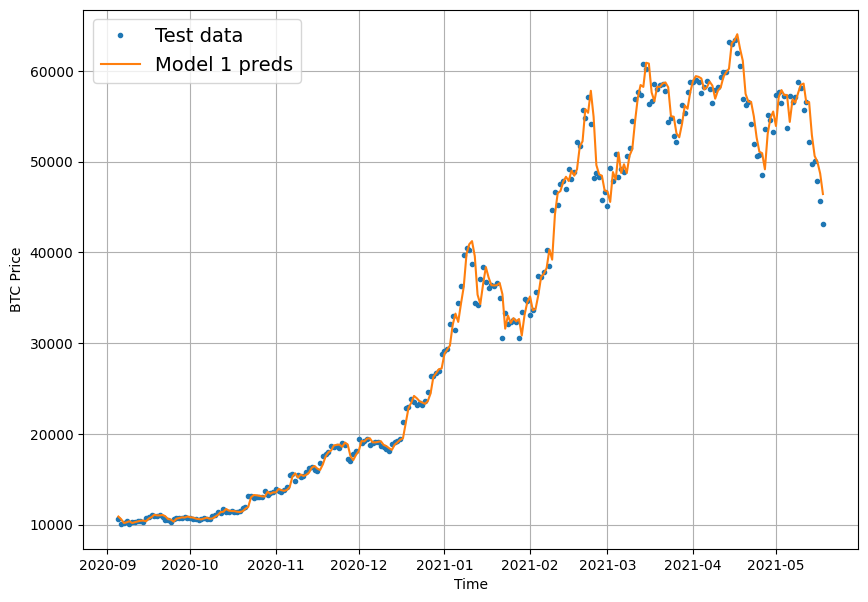

In [ ]:
# Let's plot our model 1 predictions
offset= 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 preds")

## Windowing dataset
Windowing data with larger window size and horizon

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
train_windows[1],train_labels[:10]

(array([125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
        135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
        160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
        175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499]),
 array([[196.02499],
        [198.04883],
        [198.93233],
        [200.543  ],
        [210.3075 ],
        [225.02   ],
        [248.25333],
        [262.32666],
        [294.48699],
        [331.10325]]))

In [ ]:
train_windows.shape, test_labels.shape

((2205, 30), (552, 1))

## Model 2: Dense (window=30, horizon=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_2 = tf.keras.Sequential([
    layers.Dense(228, activation="relu"),
    layers.Dense(HORIZON, activation="linear")# linear activation is the same as having no activation
], name="model_2_dense")

# 2. Compile the model
model_2.compile(loss="mae",
                optimizer="adam",
                metrics=["mae", "mse"])

# 3. Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data= (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 16s - loss: 3286.8555 - mae: 3286.8555 - mse: 26790524.0000

18/18 [==============================] - 2s 39ms/step - loss: 1249.3671 - mae: 1249.3671 - mse: 6204511.0000 - val_loss: 5140.0146 - val_mae: 5140.0146 - val_mse: 55254020.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 712.0082 - mae: 712.0082 - mse: 2132374.7500

18/18 [==============================] - 1s 30ms/step - loss: 503.6643 - mae: 503.6643 - mse: 1097710.1250 - val_loss: 1830.0446 - val_mae: 1830.0446 - val_mse: 9295076.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 400.9319 - mae: 400.9319 - mse: 843688.8125

18/18 [==============================] - 1s 29ms/step - loss: 336.0802 - mae: 336.0802 - mse: 518201.2812 - val_loss: 1352.6046 - val_mae: 1352.6046 - val_mse: 5551235.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 200.1990 - mae: 200.1990 - mse: 194868.7969

18/18 [==============================] - 1s 40ms/step - loss: 245.4025 - mae: 245.4025 - mse: 279263.5938 - val_loss: 1253.8684 - val_mae: 1253.8684 - val_mse: 4528335.0000
Epoch 5/100
15/18 [========================>.....] - ETA: 0s - loss: 197.5567 - mae: 197.5567 - mse: 199971.4844

18/18 [==============================] - 1s 45ms/step - loss: 201.8311 - mae: 201.8311 - mse: 203779.4062 - val_loss: 1096.8108 - val_mae: 1096.8108 - val_mse: 3938832.7500
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 216.6137 - mae: 216.6137 - mse: 226132.3906

18/18 [==============================] - 1s 46ms/step - loss: 210.6282 - mae: 210.6282 - mse: 212343.2656 - val_loss: 987.7063 - val_mae: 987.7063 - val_mse: 3238842.7500
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 178.5807 - mae: 178.5807 - mse: 163023.1875 - val_loss: 1074.9637 - val_mae: 1074.9637 - val_mse: 3712405.2500
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 169.1038 - mae: 169.1038 - mse: 153943.9688

18/18 [==============================] - 1s 30ms/step - loss: 169.1038 - mae: 169.1038 - mse: 153943.9688 - val_loss: 924.9726 - val_mae: 924.9726 - val_mse: 2815733.7500
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 169.2802 - mae: 169.2802 - mse: 146473.9688

18/18 [==============================] - 1s 34ms/step - loss: 169.3266 - mae: 169.3266 - mse: 145679.5312 - val_loss: 897.8115 - val_mae: 897.8115 - val_mse: 2589884.0000
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 165.8085 - mae: 165.8085 - mse: 138021.0938 - val_loss: 911.1243 - val_mae: 911.1243 - val_mse: 2709890.2500
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 163.8680 - mae: 163.8680 - mse: 138966.1562 - val_loss: 1011.6884 - val_mae: 1011.6884 - val_mse: 2871640.2500
Epoch 12/100
18/18 [==============================] - ETA: 0s - loss: 157.5790 - mae: 157.5790 - mse: 129411.8281

18/18 [==============================] - 1s 30ms/step - loss: 157.5790 - mae: 157.5790 - mse: 129411.8281 - val_loss: 895.4699 - val_mae: 895.4699 - val_mse: 2425013.5000
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 150.4989 - mae: 150.4989 - mse: 119502.8828 - val_loss: 1056.6377 - val_mae: 1056.6377 - val_mse: 3469711.0000
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 162.6444 - mae: 162.6444 - mse: 132234.4531 - val_loss: 1152.2913 - val_mae: 1152.2913 - val_mse: 3439888.7500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 186.6682 - mae: 186.6682 - mse: 114169.9141

18/18 [==============================] - 1s 30ms/step - loss: 152.1980 - mae: 152.1980 - mse: 117807.8828 - val_loss: 812.3372 - val_mae: 812.3372 - val_mse: 2163981.5000
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 143.2378 - mae: 143.2378 - mse: 111101.3438

18/18 [==============================] - 1s 30ms/step - loss: 170.8961 - mae: 170.8961 - mse: 133884.9375 - val_loss: 798.8065 - val_mae: 798.8065 - val_mse: 2081951.1250
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 152.2373 - mae: 152.2373 - mse: 114450.4688 - val_loss: 956.2704 - val_mae: 956.2704 - val_mse: 2576694.7500
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 149.5682 - mae: 149.5682 - mse: 111729.2734 - val_loss: 812.7200 - val_mae: 812.7200 - val_mse: 2046716.2500
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 141.9297 - mae: 141.9297 - mse: 102529.0469 - val_loss: 1637.2396 - val_mae: 1637.2396 - val_mse: 6615467.5000
Epoch 20/100
18/18 [==============================] - 0s 6ms/step - loss: 174.4114 - mae: 174.4114 - mse: 135615.4375 - val_loss: 939.1982 - val_mae: 939.1982 - val_mse: 2774981.0000
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 176.0395 - mae: 176.0

18/18 [==============================] - 1s 31ms/step - loss: 142.4899 - mae: 142.4899 - mse: 101669.8594 - val_loss: 750.9359 - val_mae: 750.9359 - val_mse: 1898793.8750
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 169.2294 - mae: 169.2294 - mse: 109284.3750

18/18 [==============================] - 1s 29ms/step - loss: 143.1669 - mae: 143.1669 - mse: 104240.8594 - val_loss: 740.0980 - val_mae: 740.0980 - val_mse: 1841757.8750
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 133.2575 - mae: 133.2575 - mse: 95576.3906 - val_loss: 756.8644 - val_mae: 756.8644 - val_mse: 1929186.1250
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 140.2977 - mae: 140.2977 - mse: 101762.3516 - val_loss: 816.8671 - val_mae: 816.8671 - val_mse: 2000600.6250
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 138.4603 - mae: 138.4603 - mse: 95938.9062 - val_loss: 762.1667 - val_mae: 762.1667 - val_mse: 1949249.1250
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 115.7649 - mae: 115.7649 - mse: 46962.6367

18/18 [==============================] - 0s 29ms/step - loss: 130.6497 - mae: 130.6497 - mse: 92602.3203 - val_loss: 731.4971 - val_mae: 731.4971 - val_mse: 1726371.0000
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 104.2297 - mae: 104.2297 - mse: 86693.0078

18/18 [==============================] - 1s 29ms/step - loss: 133.6572 - mae: 133.6572 - mse: 95959.7969 - val_loss: 700.2490 - val_mae: 700.2490 - val_mse: 1646222.3750
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 147.8152 - mae: 147.8152 - mse: 107749.6562 - val_loss: 743.0216 - val_mae: 743.0216 - val_mse: 1733584.6250
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 149.5169 - mae: 149.5169 - mse: 104451.1094

18/18 [==============================] - 1s 30ms/step - loss: 149.5169 - mae: 149.5169 - mse: 104451.1094 - val_loss: 694.8867 - val_mae: 694.8867 - val_mse: 1636482.7500
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 171.9344 - mae: 171.9344 - mse: 123056.5312 - val_loss: 707.5861 - val_mae: 707.5861 - val_mse: 1681689.0000
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 131.5145 - mae: 131.5145 - mse: 90399.1875 - val_loss: 915.3309 - val_mae: 915.3309 - val_mse: 2305575.2500
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 145.6226 - mae: 145.6226 - mse: 102676.9453 - val_loss: 1004.8913 - val_mae: 1004.8913 - val_mse: 2915668.0000
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 161.4859 - mae: 161.4859 - mse: 115467.8359 - val_loss: 779.9615 - val_mae: 779.9615 - val_mse: 1945292.2500
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 125.3254 - mae: 125.32

18/18 [==============================] - 0s 28ms/step - loss: 125.2981 - mae: 125.2981 - mse: 87272.6094 - val_loss: 672.5761 - val_mae: 672.5761 - val_mse: 1562085.6250
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 128.9550 - mae: 128.9550 - mse: 87636.8438 - val_loss: 698.6880 - val_mae: 698.6880 - val_mse: 1664884.3750
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 129.5936 - mae: 129.5936 - mse: 86315.4844 - val_loss: 822.4507 - val_mae: 822.4507 - val_mse: 2173565.0000
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 128.5753 - mae: 128.5753 - mse: 87671.2891 - val_loss: 689.7784 - val_mae: 689.7784 - val_mse: 1553765.1250
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 121.5883 - mae: 121.5883 - mse: 81077.2812 - val_loss: 771.8295 - val_mae: 771.8295 - val_mse: 1768379.8750
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 125.5667 - mae: 125.5667 - m

18/18 [==============================] - 1s 30ms/step - loss: 123.1171 - mae: 123.1171 - mse: 86201.2344 - val_loss: 636.7126 - val_mae: 636.7126 - val_mse: 1378927.5000
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 120.1360 - mae: 120.1360 - mse: 79898.2266 - val_loss: 643.5746 - val_mae: 643.5746 - val_mse: 1399527.2500
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 122.3289 - mae: 122.3289 - mse: 80728.1016 - val_loss: 872.3565 - val_mae: 872.3565 - val_mse: 2228239.7500
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 181.8447 - mae: 181.8447 - mse: 129979.9688 - val_loss: 792.3543 - val_mae: 792.3543 - val_mse: 1894434.5000
Epoch 51/100
14/18 [======================>.......] - ETA: 0s - loss: 129.8309 - mae: 129.8309 - mse: 75134.5000

18/18 [==============================] - 1s 43ms/step - loss: 127.8827 - mae: 127.8827 - mse: 81598.4219 - val_loss: 630.9144 - val_mae: 630.9144 - val_mse: 1369879.6250
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 122.6771 - mae: 122.6771 - mse: 83997.2500 - val_loss: 649.9393 - val_mae: 649.9393 - val_mse: 1393861.3750
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 118.7875 - mae: 118.7875 - mse: 78106.6562 - val_loss: 743.3649 - val_mae: 743.3649 - val_mse: 1718301.2500
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 121.3753 - mae: 121.3753 - mse: 79052.4453 - val_loss: 686.8266 - val_mae: 686.8266 - val_mse: 1480576.6250
Epoch 55/100
17/18 [===========================>..] - ETA: 0s - loss: 113.4927 - mae: 113.4927 - mse: 71083.4219

18/18 [==============================] - 1s 30ms/step - loss: 114.5463 - mae: 114.5463 - mse: 74719.4688 - val_loss: 619.8301 - val_mae: 619.8301 - val_mse: 1327380.7500
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 127.6768 - mae: 127.6768 - mse: 83798.0312 - val_loss: 731.5627 - val_mae: 731.5627 - val_mse: 1691108.0000
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 130.9294 - mae: 130.9294 - mse: 82318.7578 - val_loss: 1261.3961 - val_mae: 1261.3961 - val_mse: 3603076.7500
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 180.6431 - mae: 180.6431 - mse: 128828.8516 - val_loss: 663.8777 - val_mae: 663.8777 - val_mse: 1404182.0000
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7170 - mae: 116.7170 - mse: 76183.7344 - val_loss: 960.1074 - val_mae: 960.1074 - val_mse: 2366003.0000
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 125.7820 - mae: 125.7820 

18/18 [==============================] - 0s 29ms/step - loss: 122.2341 - mae: 122.2341 - mse: 80597.5938 - val_loss: 616.8585 - val_mae: 616.8585 - val_mse: 1296416.3750
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 118.1794 - mae: 118.1794 - mse: 78663.3203 - val_loss: 621.1730 - val_mae: 621.1730 - val_mse: 1334402.0000
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3460 - mae: 121.3460 - mse: 79672.2812 - val_loss: 647.9011 - val_mae: 647.9011 - val_mse: 1349195.6250
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4505 - mae: 116.4505 - mse: 76173.2969 - val_loss: 652.0790 - val_mae: 652.0790 - val_mse: 1400575.0000
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 126.4087 - mae: 126.4087 - mse: 82247.1797 - val_loss: 621.3642 - val_mae: 621.3642 - val_mse: 1328888.6250
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 113.7951 - mae: 113.7951 - m

18/18 [==============================] - 1s 30ms/step - loss: 112.6196 - mae: 112.6196 - mse: 73343.7188 - val_loss: 610.3286 - val_mae: 610.3286 - val_mse: 1281903.2500
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 124.8831 - mae: 124.8831 - mse: 81036.7266 - val_loss: 895.2902 - val_mae: 895.2902 - val_mse: 2116268.5000
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 148.9402 - mae: 148.9402 - mse: 95322.8359 - val_loss: 1216.9917 - val_mae: 1216.9917 - val_mse: 3395830.7500
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 144.3020 - mae: 144.3020 - mse: 92455.0859 - val_loss: 809.4535 - val_mae: 809.4535 - val_mse: 1830782.8750
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 133.3172 - mae: 133.3172 - mse: 87111.1875 - val_loss: 615.2721 - val_mae: 615.2721 - val_mse: 1292388.0000
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 137.2630 - mae: 137.2630 -

18/18 [==============================] - 1s 45ms/step - loss: 116.9973 - mae: 116.9973 - mse: 74482.0000 - val_loss: 598.8964 - val_mae: 598.8964 - val_mse: 1228373.6250
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 130.0324 - mae: 130.0324 - mse: 82145.0156 - val_loss: 624.6100 - val_mae: 624.6100 - val_mse: 1319341.2500
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 129.3829 - mae: 129.3829 - mse: 81611.2422 - val_loss: 755.2074 - val_mae: 755.2074 - val_mse: 1656166.7500
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 118.7292 - mae: 118.7292 - mse: 77075.7656 - val_loss: 742.7304 - val_mae: 742.7304 - val_mse: 1625885.2500
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 126.4144 - mae: 126.4144 - mse: 79521.3281 - val_loss: 812.1566 - val_mae: 812.1566 - val_mse: 1904213.5000
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 140.7203 - mae: 140.7203 - m

18/18 [==============================] - 1s 31ms/step - loss: 124.6141 - mae: 124.6141 - mse: 76886.5859 - val_loss: 592.9671 - val_mae: 592.9671 - val_mse: 1218816.8750
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 115.8281 - mae: 115.8281 - mse: 71854.8281 - val_loss: 683.0743 - val_mae: 683.0743 - val_mse: 1434716.0000
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 130.3403 - mae: 130.3403 - mse: 84276.7812 - val_loss: 600.6645 - val_mae: 600.6645 - val_mse: 1249039.7500
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 114.3720 - mae: 114.3720 - mse: 72374.1406 - val_loss: 594.8352 - val_mae: 594.8352 - val_mse: 1220085.6250
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1017 - mae: 119.1017 - mse: 77160.6484 - val_loss: 687.4531 - val_mae: 687.4531 - val_mse: 1478172.5000
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 119.9040 - mae: 119.9040 - m

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 772.5485 - mae: 772.5485 - mse: 1741262.3750


[772.5485229492188, 772.5485229492188, 1741262.375]

In [ ]:
# load in saved best performance model_1 and evaluate it on test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 592.9672 - mae: 592.9672 - mse: 1218816.7500


[592.9671630859375, 592.9671630859375, 1218816.75]

In [ ]:
model_2_preds =make_preds(model_2, test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 592.96716,
 'mape': 2.6852548,
 'mase': 1.0365124,
 'mse': 1218816.9,
 'rmse': 1104.0004}

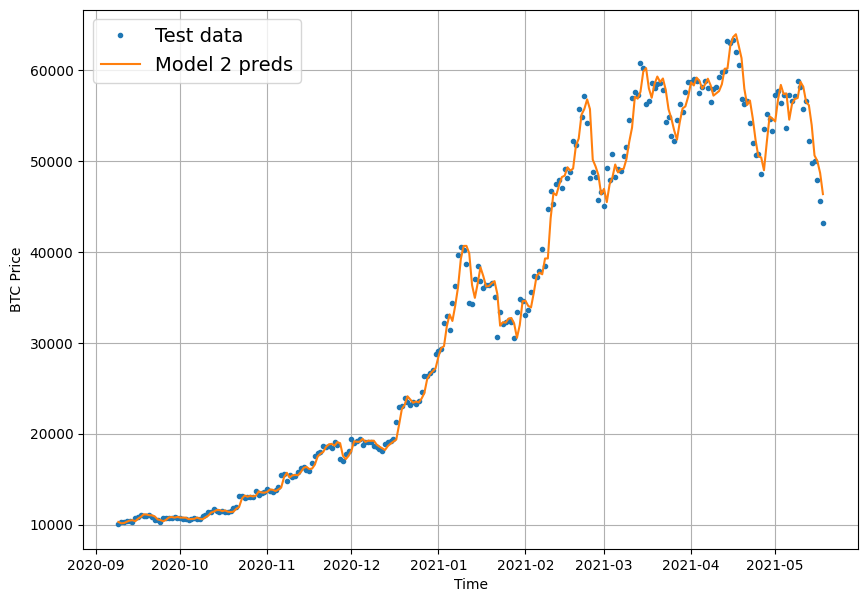

In [ ]:
# Let's plot our model 1 predictions
offset= 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label="Model 2 preds")

## Model: 3 Dense(window_size=30, horizon=7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
# spliting to train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
train_windows.shape , len(train_windows),train_labels.shape, len(train_labels)

((2200, 30), 2200, (2200, 7), 2200)

In [ ]:
test_windows.shape, len(test_windows), test_labels.shape, len(test_labels)

((551, 30), 551, (551, 7), 551)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_3 = tf.keras.Sequential([
    layers.Dense(228, activation="relu"),
    layers.Dense(HORIZON, activation="linear")# linear activation is the same as having no activation
], name="model_3_dense")

# 2. Compile the model
model_3.compile(loss="mae",
                optimizer="adam",
                metrics=["mae", "mse"])

# 3. Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data= (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 2019.2909 - mae: 2019.2909 - mse: 17352964.0000 

18/18 [==============================] - 2s 39ms/step - loss: 1849.8593 - mae: 1849.8593 - mse: 15366016.0000 - val_loss: 3362.9900 - val_mae: 3362.9900 - val_mse: 28506562.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 602.1309 - mae: 602.1309 - mse: 1379788.0000

18/18 [==============================] - 1s 32ms/step - loss: 537.4691 - mae: 537.4691 - mse: 1239517.6250 - val_loss: 2256.2034 - val_mae: 2256.2034 - val_mse: 14795010.0000
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 405.2325 - mae: 405.2325 - mse: 756610.2500

18/18 [==============================] - 1s 46ms/step - loss: 392.0689 - mae: 392.0689 - mse: 736538.0625 - val_loss: 2047.5549 - val_mae: 2047.5549 - val_mse: 12238775.0000
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 350.1586 - mae: 350.1586 - mse: 599162.8125

18/18 [==============================] - 1s 42ms/step - loss: 345.6213 - mae: 345.6213 - mse: 587147.7500 - val_loss: 1823.9921 - val_mae: 1823.9921 - val_mse: 10078806.0000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 392.9916 - mae: 392.9916 - mse: 816264.5000

18/18 [==============================] - 1s 30ms/step - loss: 318.6926 - mae: 318.6926 - mse: 502663.9062 - val_loss: 1774.5323 - val_mae: 1774.5323 - val_mse: 9601109.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 267.4138 - mae: 267.4138 - mse: 322556.4375

18/18 [==============================] - 1s 30ms/step - loss: 299.1149 - mae: 299.1149 - mse: 445079.7812 - val_loss: 1637.4966 - val_mae: 1637.4966 - val_mse: 8207772.5000
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 291.9323 - mae: 291.9323 - mse: 429823.5625

18/18 [==============================] - 1s 31ms/step - loss: 286.7393 - mae: 286.7393 - mse: 411278.5312 - val_loss: 1548.2094 - val_mae: 1548.2094 - val_mse: 7535736.0000
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 282.1277 - mae: 282.1277 - mse: 389918.7500

18/18 [==============================] - 1s 34ms/step - loss: 283.2938 - mae: 283.2938 - mse: 392631.6875 - val_loss: 1514.5814 - val_mae: 1514.5814 - val_mse: 7208304.0000
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 272.6634 - mae: 272.6634 - mse: 374258.5312 - val_loss: 1550.0334 - val_mae: 1550.0334 - val_mse: 7475456.5000
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 270.5619 - mae: 270.5619 - mse: 360993.4375

18/18 [==============================] - 1s 31ms/step - loss: 272.1258 - mae: 272.1258 - mse: 366369.2500 - val_loss: 1485.5214 - val_mae: 1485.5214 - val_mse: 7108003.0000
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 267.7462 - mae: 267.7462 - mse: 355567.6250

18/18 [==============================] - 1s 31ms/step - loss: 266.3865 - mae: 266.3865 - mse: 358402.7188 - val_loss: 1464.4823 - val_mae: 1464.4823 - val_mse: 6879693.5000
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 263.0273 - mae: 263.0273 - mse: 353197.0000 - val_loss: 1557.6931 - val_mae: 1557.6931 - val_mse: 7451841.0000
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 255.9498 - mae: 255.9498 - mse: 340635.6562

18/18 [==============================] - 1s 31ms/step - loss: 255.9498 - mae: 255.9498 - mse: 340635.6562 - val_loss: 1416.3833 - val_mae: 1416.3833 - val_mse: 6602009.5000
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 261.2161 - mae: 261.2161 - mse: 347265.1562 - val_loss: 1422.6515 - val_mae: 1422.6515 - val_mse: 6523069.5000
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 257.2710 - mae: 257.2710 - mse: 337280.5625 - val_loss: 1553.7003 - val_mae: 1553.7003 - val_mse: 7277299.5000
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 246.0193 - mae: 246.0193 - mse: 215661.0156

18/18 [==============================] - 1s 44ms/step - loss: 254.1616 - mae: 254.1616 - mse: 329257.6875 - val_loss: 1410.4905 - val_mae: 1410.4905 - val_mse: 6381935.0000
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 253.0593 - mae: 253.0593 - mse: 331973.6875 - val_loss: 1611.7213 - val_mae: 1611.7213 - val_mse: 7676667.0000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 292.7318 - mae: 292.7318 - mse: 378492.8125

18/18 [==============================] - 1s 31ms/step - loss: 257.6809 - mae: 257.6809 - mse: 330408.7812 - val_loss: 1407.3938 - val_mae: 1407.3938 - val_mse: 6398406.0000
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 248.9063 - mae: 248.9063 - mse: 319531.9062 - val_loss: 1559.4128 - val_mae: 1559.4128 - val_mse: 7225386.5000
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 242.0092 - mae: 242.0092 - mse: 308636.8750

18/18 [==============================] - 1s 30ms/step - loss: 252.8841 - mae: 252.8841 - mse: 320499.9375 - val_loss: 1401.4062 - val_mae: 1401.4062 - val_mse: 6507777.0000
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 303.5865 - mae: 303.5865 - mse: 425748.5312

18/18 [==============================] - 1s 30ms/step - loss: 246.6230 - mae: 246.6230 - mse: 312788.7188 - val_loss: 1392.1786 - val_mae: 1392.1786 - val_mse: 6312205.5000
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 246.7828 - mae: 246.7828 - mse: 310966.1562 - val_loss: 1490.9707 - val_mae: 1490.9707 - val_mse: 6684339.5000
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 254.4790 - mae: 254.4790 - mse: 320736.1875 - val_loss: 1399.0497 - val_mae: 1399.0497 - val_mse: 6472787.5000
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 311.4753 - mae: 311.4753 - mse: 471216.6875

18/18 [==============================] - 1s 30ms/step - loss: 261.8528 - mae: 261.8528 - mse: 334940.0000 - val_loss: 1345.8512 - val_mae: 1345.8512 - val_mse: 5983699.0000
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 248.5178 - mae: 248.5178 - mse: 308641.2812 - val_loss: 1602.1393 - val_mae: 1602.1393 - val_mse: 7676078.0000
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 246.1147 - mae: 246.1147 - mse: 311135.0938 - val_loss: 1415.6505 - val_mae: 1415.6505 - val_mse: 6333672.5000
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 238.8105 - mae: 238.8105 - mse: 301540.2188 - val_loss: 1390.4810 - val_mae: 1390.4810 - val_mse: 6112567.5000
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 219.5535 - mae: 219.5535 - mse: 240934.9688

18/18 [==============================] - 0s 29ms/step - loss: 237.8456 - mae: 237.8456 - mse: 295073.5625 - val_loss: 1325.5662 - val_mae: 1325.5662 - val_mse: 5884927.0000
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 234.5789 - mae: 234.5789 - mse: 293852.3125 - val_loss: 1346.0447 - val_mae: 1346.0447 - val_mse: 5949965.5000
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 237.2539 - mae: 237.2539 - mse: 299739.4375 - val_loss: 1389.0862 - val_mae: 1389.0862 - val_mse: 6280428.0000
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 234.0620 - mae: 234.0620 - mse: 289437.9688 - val_loss: 1352.0571 - val_mae: 1352.0571 - val_mse: 5990695.0000
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 231.1955 - mae: 231.1955 - mse: 213192.9531

18/18 [==============================] - 0s 29ms/step - loss: 237.2264 - mae: 237.2264 - mse: 294263.5938 - val_loss: 1302.6934 - val_mae: 1302.6934 - val_mse: 5780221.5000
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 219.2242 - mae: 219.2242 - mse: 275202.5938

18/18 [==============================] - 1s 30ms/step - loss: 232.6080 - mae: 232.6080 - mse: 289041.0938 - val_loss: 1302.2657 - val_mae: 1302.2657 - val_mse: 5795614.0000
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 237.4482 - mae: 237.4482 - mse: 292061.2500 - val_loss: 1365.9918 - val_mae: 1365.9918 - val_mse: 6032467.5000
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 238.7938 - mae: 238.7938 - mse: 294620.0000 - val_loss: 1397.3175 - val_mae: 1397.3175 - val_mse: 6305810.5000
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 238.8763 - mae: 238.8763 - mse: 297154.9062 - val_loss: 1371.9647 - val_mae: 1371.9647 - val_mse: 6296467.5000
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 255.5749 - mae: 255.5749 - mse: 315545.2812 - val_loss: 1446.2865 - val_mae: 1446.2865 - val_mse: 6408835.0000
Epoch 38/100
18/18 [==============================] - 0s 7ms/step - loss: 235.1345 - ma

18/18 [==============================] - 1s 44ms/step - loss: 241.5309 - mae: 241.5309 - mse: 301059.4375 - val_loss: 1300.3948 - val_mae: 1300.3948 - val_mse: 5698192.0000
Epoch 43/100
16/18 [=========================>....] - ETA: 0s - loss: 228.9903 - mae: 228.9903 - mse: 282226.1250

18/18 [==============================] - 1s 31ms/step - loss: 230.0798 - mae: 230.0798 - mse: 278022.3438 - val_loss: 1267.7692 - val_mae: 1267.7692 - val_mse: 5602328.0000
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 231.2179 - mae: 231.2179 - mse: 283941.8438 - val_loss: 1309.8378 - val_mae: 1309.8378 - val_mse: 5764085.0000
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 228.4480 - mae: 228.4480 - mse: 279066.0000 - val_loss: 1331.8175 - val_mae: 1331.8175 - val_mse: 5822846.0000
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 235.9660 - mae: 235.9660 - mse: 283577.9688 - val_loss: 1303.5266 - val_mae: 1303.5266 - val_mse: 5650072.0000
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 233.5066 - mae: 233.5066 - mse: 286295.8750 - val_loss: 1288.8800 - val_mae: 1288.8800 - val_mse: 5615018.5000
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 228.4570 - ma

18/18 [==============================] - 1s 31ms/step - loss: 228.2664 - mae: 228.2664 - mse: 276493.9688 - val_loss: 1232.0793 - val_mae: 1232.0793 - val_mse: 5348645.0000
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 227.3763 - mae: 227.3763 - mse: 277869.9062 - val_loss: 1260.4918 - val_mae: 1260.4918 - val_mse: 5584500.0000
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 226.7474 - mae: 226.7474 - mse: 271906.6250 - val_loss: 1253.3904 - val_mae: 1253.3904 - val_mse: 5404240.0000
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 223.8749 - mae: 223.8749 - mse: 269604.1562 - val_loss: 1280.7781 - val_mae: 1280.7781 - val_mse: 5520035.5000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 232.3147 - mae: 232.3147 - mse: 282960.6875 - val_loss: 1371.0836 - val_mae: 1371.0836 - val_mse: 6025988.0000
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 226.1742 - ma

18/18 [==============================] - 1s 31ms/step - loss: 226.0116 - mae: 226.0116 - mse: 270605.4375 - val_loss: 1227.1603 - val_mae: 1227.1603 - val_mse: 5257336.0000
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 225.9961 - mae: 225.9961 - mse: 263908.0000 - val_loss: 1234.9297 - val_mae: 1234.9297 - val_mse: 5321996.5000
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 223.0878 - mae: 223.0878 - mse: 264112.0625 - val_loss: 1252.2216 - val_mae: 1252.2216 - val_mse: 5441612.5000
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 222.5242 - mae: 222.5242 - mse: 264779.6250 - val_loss: 1263.3883 - val_mae: 1263.3883 - val_mse: 5452427.5000
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 223.1989 - mae: 223.1989 - mse: 264494.1875 - val_loss: 1371.6838 - val_mae: 1371.6838 - val_mse: 6012544.0000
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 230.8555 - ma

In [ ]:
# load in saved best performance model_1 and evaluate it on test data
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1227.1604 - mae: 1227.1604 - mse: 5257336.0000


[1227.160400390625, 1227.160400390625, 5257336.0]

In [ ]:
# Evaluating the model
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[9381.203 , 9445.443 , 9427.535 , 9232.546 , 9544.346 , 9490.639 ,
        9439.072 ],
       [8897.94  , 9011.126 , 9123.014 , 8803.513 , 9218.715 , 9178.6455,
        9243.033 ],
       [8679.714 , 8882.995 , 8976.139 , 8561.614 , 9017.581 , 9197.002 ,
        9157.904 ],
       [8801.634 , 9003.711 , 9013.857 , 8849.706 , 9078.18  , 9309.257 ,
        9283.43  ],
       [8789.202 , 8852.349 , 9072.008 , 8875.249 , 8871.584 , 9029.103 ,
        8995.322 ],
       [8759.484 , 8871.087 , 9139.337 , 8869.997 , 8807.446 , 8948.536 ,
        8910.781 ],
       [8873.162 , 8976.748 , 9171.621 , 8784.095 , 8791.725 , 8913.275 ,
        8805.941 ],
       [8776.395 , 8898.834 , 8954.899 , 8405.943 , 8645.197 , 8935.166 ,
        8571.938 ],
       [8608.949 , 8617.244 , 8709.462 , 8275.292 , 8549.218 , 8713.3545,
        8466.57  ],
       [8366.106 , 8362.266 , 8498.328 , 8377.084 , 8453.832 , 8457.141 ,
        8526.068 ]], dtype=floa

## Make our evaluation function work for larger horizons

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype(for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred , dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae":mae.numpy(),
           "mape": mape.numpy(),
          "mase": mase.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
         }

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1227.1603,
 'mape': 5.4967046,
 'mase': 2.1836634,
 'mse': 5257335.5,
 'rmse': 1411.1775}

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

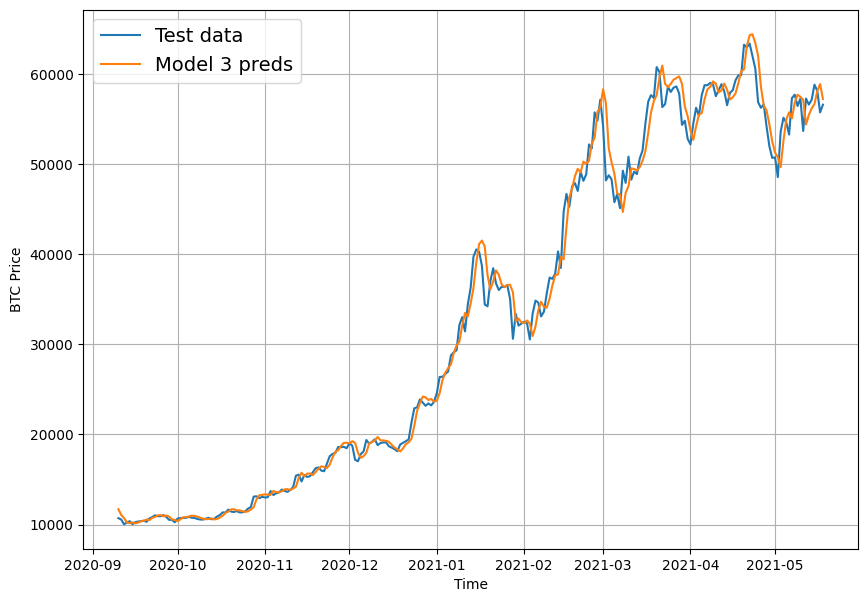

In [ ]:
# Let's plot our model 3 predictions
offset= 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to
# ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 format="-",
                 start=offset,
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="Model 3 preds")

## Which of our models is performing the best so far?

So, we've trained a few models, now let's compare them and see how they've gone...

<Axes: >

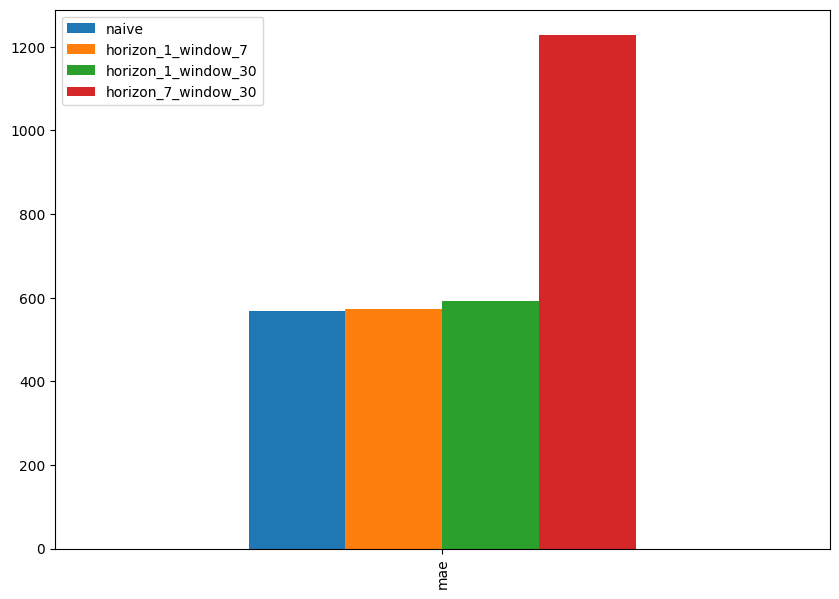

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

## Model 4: Conv1D  


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create a windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test split
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However, our data isn't in that shape yet...

In [ ]:
# Check data shape
train_windows[0].shape #returns (WINDOWS_SIZE,)

(7,)

In [ ]:
# Before we pass out data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) #add an extra dimension for `input_dim`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") #output = ...?
print(f"Original values with expanded shape:/n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:/n [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create Conv1D
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# compile the model
model_4.compile(optimizer="adam",
                loss="mae",
                metrics=["mae", "mse"])

# fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name =model_4.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1333.6825 - mae: 1333.6825 - mse: 6183850.0000

18/18 [==============================] - 7s 75ms/step - loss: 1333.6825 - mae: 1333.6825 - mse: 6183850.0000 - val_loss: 1952.3660 - val_mae: 1952.3660 - val_mse: 9873871.0000
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 324.4719 - mae: 324.4719 - mse: 426376.7812

18/18 [==============================] - 1s 41ms/step - loss: 322.2406 - mae: 322.2406 - mse: 419801.1875 - val_loss: 1718.9830 - val_mae: 1718.9830 - val_mse: 7042220.5000
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 210.9465 - mae: 210.9465 - mse: 217862.5625

18/18 [==============================] - 1s 41ms/step - loss: 206.0913 - mae: 206.0913 - mse: 213482.1562 - val_loss: 1257.1271 - val_mae: 1257.1271 - val_mse: 4278031.5000
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 184.9000 - mae: 184.9000 - mse: 177925.0781

18/18 [==============================] - 1s 41ms/step - loss: 184.6838 - mae: 184.6838 - mse: 176008.2031 - val_loss: 1060.9236 - val_mae: 1060.9236 - val_mse: 3466638.7500
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 183.1823 - mae: 183.1823 - mse: 180339.2188

18/18 [==============================] - 1s 42ms/step - loss: 180.2898 - mae: 180.2898 - mse: 174456.2500 - val_loss: 1010.2687 - val_mae: 1010.2687 - val_mse: 3269362.2500
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 178.6189 - mae: 178.6189 - mse: 167107.9688 - val_loss: 1028.8040 - val_mae: 1028.8040 - val_mse: 3516584.0000
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 177.3595 - mae: 177.3595 - mse: 166481.0156

18/18 [==============================] - 1s 40ms/step - loss: 176.6413 - mae: 176.6413 - mse: 164599.9688 - val_loss: 955.7831 - val_mae: 955.7831 - val_mse: 3042808.7500
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 170.4287 - mae: 170.4287 - mse: 154575.3906 - val_loss: 958.2707 - val_mae: 958.2707 - val_mse: 2966966.5000
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 166.7642 - mae: 166.7642 - mse: 151258.0781

18/18 [==============================] - 1s 41ms/step - loss: 166.8128 - mae: 166.8128 - mse: 150391.8281 - val_loss: 954.8795 - val_mae: 954.8795 - val_mse: 2896427.5000
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 162.3322 - mae: 162.3322 - mse: 145379.8125

18/18 [==============================] - 1s 41ms/step - loss: 163.6709 - mae: 163.6709 - mse: 146097.6250 - val_loss: 909.9874 - val_mae: 909.9874 - val_mse: 2735017.0000
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 158.4705 - mae: 158.4705 - mse: 138603.6250

18/18 [==============================] - 1s 45ms/step - loss: 159.8622 - mae: 159.8622 - mse: 139211.5312 - val_loss: 896.1041 - val_mae: 896.1041 - val_mse: 2635329.5000
Epoch 12/100
18/18 [==============================] - 0s 9ms/step - loss: 157.0480 - mae: 157.0480 - mse: 134474.7969 - val_loss: 975.8658 - val_mae: 975.8658 - val_mse: 2789766.0000
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 156.6027 - mae: 156.6027 - mse: 134840.3750

18/18 [==============================] - 1s 68ms/step - loss: 156.6027 - mae: 156.6027 - mse: 134840.3750 - val_loss: 872.0860 - val_mae: 872.0860 - val_mse: 2459591.7500
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 148.5165 - mae: 148.5165 - mse: 124299.2891

18/18 [==============================] - 1s 51ms/step - loss: 150.6922 - mae: 150.6922 - mse: 125674.1406 - val_loss: 864.5684 - val_mae: 864.5684 - val_mse: 2384036.0000
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 150.7436 - mae: 150.7436 - mse: 124586.3438 - val_loss: 890.2026 - val_mae: 890.2026 - val_mse: 2400115.5000
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 148.4084 - mae: 148.4084 - mse: 122002.2891

18/18 [==============================] - 1s 41ms/step - loss: 146.7347 - mae: 146.7347 - mse: 119849.6094 - val_loss: 812.3386 - val_mae: 812.3386 - val_mse: 2171135.5000
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 143.0606 - mae: 143.0606 - mse: 111688.1719

18/18 [==============================] - 1s 60ms/step - loss: 144.2323 - mae: 144.2323 - mse: 114769.2344 - val_loss: 794.5156 - val_mae: 794.5156 - val_mse: 2087040.0000
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 140.0871 - mae: 140.0871 - mse: 110114.6797 - val_loss: 804.5756 - val_mae: 804.5756 - val_mse: 2059926.1250
Epoch 19/100
17/18 [===========================>..] - ETA: 0s - loss: 138.1791 - mae: 138.1791 - mse: 106970.2109

18/18 [==============================] - 1s 41ms/step - loss: 137.3775 - mae: 137.3775 - mse: 106442.1406 - val_loss: 766.3373 - val_mae: 766.3373 - val_mse: 1943172.6250
Epoch 20/100
18/18 [==============================] - 0s 6ms/step - loss: 137.3103 - mae: 137.3103 - mse: 106835.5312 - val_loss: 776.8086 - val_mae: 776.8086 - val_mse: 2023694.7500
Epoch 21/100
14/18 [======================>.......] - ETA: 0s - loss: 137.2455 - mae: 137.2455 - mse: 101832.6797

18/18 [==============================] - 1s 41ms/step - loss: 136.9938 - mae: 136.9938 - mse: 105082.0156 - val_loss: 732.8118 - val_mae: 732.8118 - val_mse: 1822231.7500
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 134.4714 - mae: 134.4714 - mse: 101752.7656

18/18 [==============================] - 1s 40ms/step - loss: 134.0611 - mae: 134.0611 - mse: 100955.3281 - val_loss: 720.5833 - val_mae: 720.5833 - val_mse: 1756651.2500
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 129.4789 - mae: 129.4789 - mse: 91623.0234

18/18 [==============================] - 1s 42ms/step - loss: 130.3474 - mae: 130.3474 - mse: 96418.5000 - val_loss: 717.4716 - val_mae: 717.4716 - val_mse: 1713087.2500
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 130.9753 - mae: 130.9753 - mse: 95708.1094

18/18 [==============================] - 1s 41ms/step - loss: 129.4040 - mae: 129.4040 - mse: 94006.0703 - val_loss: 701.8007 - val_mae: 701.8007 - val_mse: 1673952.8750
Epoch 25/100
18/18 [==============================] - 0s 6ms/step - loss: 127.7281 - mae: 127.7281 - mse: 90966.8672 - val_loss: 717.4135 - val_mae: 717.4135 - val_mse: 1744261.2500
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 132.9086 - mae: 132.9086 - mse: 93973.8672 - val_loss: 759.4525 - val_mae: 759.4525 - val_mse: 1899120.5000
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 130.9430 - mae: 130.9430 - mse: 93869.8516 

18/18 [==============================] - 1s 40ms/step - loss: 131.2801 - mae: 131.2801 - mse: 96059.6406 - val_loss: 696.0146 - val_mae: 696.0146 - val_mse: 1656078.2500
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 124.9387 - mae: 124.9387 - mse: 89586.3047

18/18 [==============================] - 1s 40ms/step - loss: 124.7301 - mae: 124.7301 - mse: 88530.8047 - val_loss: 670.1326 - val_mae: 670.1326 - val_mse: 1522750.1250
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 122.6062 - mae: 122.6062 - mse: 86524.4219 - val_loss: 678.4032 - val_mae: 678.4032 - val_mse: 1516312.8750
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 125.9423 - mae: 125.9423 - mse: 87159.3984 - val_loss: 728.7994 - val_mae: 728.7994 - val_mse: 1639536.3750
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 131.4337 - mae: 131.4337 - mse: 91562.9141 - val_loss: 776.8425 - val_mae: 776.8425 - val_mse: 1773302.8750
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 126.3048 - mae: 126.3048 - mse: 87114.0000 - val_loss: 676.5381 - val_mae: 676.5381 - val_mse: 1488634.5000
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1273 - mae: 119.1273 - m

18/18 [==============================] - 1s 41ms/step - loss: 121.7414 - mae: 121.7414 - mse: 84402.6172 - val_loss: 652.1442 - val_mae: 652.1442 - val_mse: 1417360.3750
Epoch 35/100
17/18 [===========================>..] - ETA: 0s - loss: 119.1650 - mae: 119.1650 - mse: 83803.7812

18/18 [==============================] - 1s 41ms/step - loss: 119.1148 - mae: 119.1148 - mse: 83017.6641 - val_loss: 647.5437 - val_mae: 647.5437 - val_mse: 1401574.2500
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 125.4551 - mae: 125.4551 - mse: 83760.7812 - val_loss: 726.7062 - val_mae: 726.7062 - val_mse: 1608723.8750
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 117.8394 - mae: 117.8394 - mse: 76640.1484 

18/18 [==============================] - 1s 61ms/step - loss: 118.6736 - mae: 118.6736 - mse: 80243.8594 - val_loss: 626.0627 - val_mae: 626.0627 - val_mse: 1369111.8750
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 117.1407 - mae: 117.1407 - mse: 81227.6562 - val_loss: 628.0488 - val_mae: 628.0488 - val_mse: 1375028.6250
Epoch 39/100
18/18 [==============================] - 0s 9ms/step - loss: 119.4870 - mae: 119.4870 - mse: 81022.5625 - val_loss: 700.9016 - val_mae: 700.9016 - val_mse: 1593505.6250
Epoch 40/100
11/18 [=================>............] - ETA: 0s - loss: 115.3686 - mae: 115.3686 - mse: 79091.3125 

18/18 [==============================] - 1s 61ms/step - loss: 116.8579 - mae: 116.8579 - mse: 80383.2969 - val_loss: 620.0999 - val_mae: 620.0999 - val_mse: 1324992.1250
Epoch 41/100
16/18 [=========================>....] - ETA: 0s - loss: 117.1624 - mae: 117.1624 - mse: 82197.2031

18/18 [==============================] - 1s 42ms/step - loss: 115.1318 - mae: 115.1318 - mse: 79023.7422 - val_loss: 612.7658 - val_mae: 612.7658 - val_mse: 1316952.6250
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 117.4667 - mae: 117.4667 - mse: 81248.0000 - val_loss: 623.0888 - val_mae: 623.0888 - val_mse: 1323703.5000
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4529 - mae: 115.4529 - mse: 76880.2891 - val_loss: 617.0886 - val_mae: 617.0886 - val_mse: 1327889.8750
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 116.8391 - mae: 116.8391 - mse: 78357.9531 - val_loss: 633.0182 - val_mae: 633.0182 - val_mse: 1369324.0000
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 116.4889 - mae: 116.4889 - mse: 79598.0859 - val_loss: 637.7358 - val_mae: 637.7358 - val_mse: 1352682.1250
Epoch 46/100
17/18 [===========================>..] - ETA: 0s - loss: 114.6985 - mae: 114.6985 - mse: 

18/18 [==============================] - 1s 43ms/step - loss: 114.9560 - mae: 114.9560 - mse: 77973.7266 - val_loss: 607.9107 - val_mae: 607.9107 - val_mse: 1283137.5000
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5890 - mae: 112.5890 - mse: 76138.9609 - val_loss: 628.7996 - val_mae: 628.7996 - val_mse: 1328472.8750
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3528 - mae: 113.3528 - mse: 76758.3516 - val_loss: 640.6534 - val_mae: 640.6534 - val_mse: 1355139.5000
Epoch 49/100
17/18 [===========================>..] - ETA: 0s - loss: 119.2865 - mae: 119.2865 - mse: 78270.3828 

18/18 [==============================] - 1s 40ms/step - loss: 118.5472 - mae: 118.5472 - mse: 77512.6641 - val_loss: 595.4757 - val_mae: 595.4757 - val_mse: 1256106.7500
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4771 - mae: 111.4771 - mse: 75518.0156 - val_loss: 636.2249 - val_mae: 636.2249 - val_mse: 1363840.5000
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8290 - mae: 112.8290 - mse: 75565.6172 - val_loss: 604.7153 - val_mae: 604.7153 - val_mse: 1266181.6250
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 113.8119 - mae: 113.8119 - mse: 77032.0859 - val_loss: 615.1370 - val_mae: 615.1370 - val_mse: 1303829.6250
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 117.4582 - mae: 117.4582 - mse: 77983.9297 - val_loss: 599.7539 - val_mae: 599.7539 - val_mse: 1253249.0000
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9752 - mae: 113.9752 - m

18/18 [==============================] - 1s 42ms/step - loss: 115.3215 - mae: 115.3215 - mse: 77758.8047 - val_loss: 591.9407 - val_mae: 591.9407 - val_mse: 1244785.0000
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 111.5928 - mae: 111.5928 - mse: 74752.2969 - val_loss: 773.0267 - val_mae: 773.0267 - val_mse: 1777226.5000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 129.7836 - mae: 129.7836 - mse: 87394.1719 - val_loss: 736.7034 - val_mae: 736.7034 - val_mse: 1659347.3750
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 124.0602 - mae: 124.0602 - mse: 82218.1641 - val_loss: 693.7516 - val_mae: 693.7516 - val_mse: 1522951.7500
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9383 - mae: 111.9383 - mse: 73373.8359 - val_loss: 610.2419 - val_mae: 610.2419 - val_mse: 1291419.2500
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 113.7918 - mae: 113.7918 - m

18/18 [==============================] - 1s 41ms/step - loss: 108.7791 - mae: 108.7791 - mse: 71544.3281 - val_loss: 582.9854 - val_mae: 582.9854 - val_mse: 1216767.2500
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1703 - mae: 111.1703 - mse: 73615.1797 - val_loss: 596.6676 - val_mae: 596.6676 - val_mse: 1236322.7500
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9500 - mae: 111.9500 - mse: 73845.3984 - val_loss: 662.5248 - val_mae: 662.5248 - val_mse: 1386357.1250
Epoch 65/100
17/18 [===========================>..] - ETA: 0s - loss: 115.9634 - mae: 115.9634 - mse: 77019.5078 

18/18 [==============================] - 1s 42ms/step - loss: 114.8971 - mae: 114.8971 - mse: 75888.6797 - val_loss: 580.2258 - val_mae: 580.2258 - val_mse: 1209359.5000
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9451 - mae: 110.9451 - mse: 72279.5391 - val_loss: 583.3988 - val_mae: 583.3988 - val_mse: 1216239.7500
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3811 - mae: 108.3811 - mse: 71349.9688 - val_loss: 610.6448 - val_mae: 610.6448 - val_mse: 1281445.7500
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 114.9865 - mae: 114.9865 - mse: 72701.6797 - val_loss: 698.7339 - val_mae: 698.7339 - val_mse: 1519743.0000
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 126.1766 - mae: 126.1766 - mse: 83127.6094 - val_loss: 704.8008 - val_mae: 704.8008 - val_mse: 1540594.6250
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 120.0957 - mae: 120.0957 - m

18/18 [==============================] - 1s 42ms/step - loss: 109.0613 - mae: 109.0613 - mse: 72148.0234 - val_loss: 572.4854 - val_mae: 572.4854 - val_mse: 1184661.0000
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3892 - mae: 108.3892 - mse: 70115.0781 - val_loss: 577.5236 - val_mae: 577.5236 - val_mse: 1195883.8750
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0391 - mae: 108.0391 - mse: 70190.6953 - val_loss: 574.9558 - val_mae: 574.9558 - val_mse: 1191157.6250
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9463 - mae: 107.9463 - mse: 71737.2578 - val_loss: 594.3682 - val_mae: 594.3682 - val_mse: 1234984.8750
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9622 - mae: 108.9622 - mse: 72086.5703 - val_loss: 576.6923 - val_mae: 576.6923 - val_mse: 1186886.6250
Epoch 81/100
17/18 [===========================>..] - ETA: 0s - loss: 107.4338 - mae: 107.4338 - mse: 

18/18 [==============================] - 1s 53ms/step - loss: 107.8888 - mae: 107.8888 - mse: 70801.9844 - val_loss: 572.3743 - val_mae: 572.3743 - val_mse: 1183681.6250
Epoch 82/100
 9/18 [==============>...............] - ETA: 0s - loss: 117.8405 - mae: 117.8405 - mse: 89549.2188 

18/18 [==============================] - 1s 56ms/step - loss: 114.3456 - mae: 114.3456 - mse: 75897.7344 - val_loss: 571.9014 - val_mae: 571.9014 - val_mse: 1182125.3750
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 111.1754 - mae: 111.1754 - mse: 72335.3438 - val_loss: 670.2277 - val_mae: 670.2277 - val_mse: 1426342.0000
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 111.5259 - mae: 111.5259 - mse: 71922.8047 - val_loss: 584.9415 - val_mae: 584.9415 - val_mse: 1212660.0000
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1820 - mae: 108.1820 - mse: 70680.9688 - val_loss: 615.0229 - val_mae: 615.0229 - val_mse: 1258194.7500
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7540 - mae: 109.7540 - mse: 70484.6797 - val_loss: 606.5377 - val_mae: 606.5377 - val_mse: 1239140.5000
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 107.1219 - mae: 107.1219 - m

18/18 [==============================] - 1s 40ms/step - loss: 108.0340 - mae: 108.0340 - mse: 70132.7422 - val_loss: 569.0143 - val_mae: 569.0143 - val_mse: 1172073.8750
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 107.1132 - mae: 107.1132 - mse: 68301.5000 - val_loss: 613.0292 - val_mae: 613.0292 - val_mse: 1251263.1250
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5125 - mae: 112.5125 - mse: 72998.9297 - val_loss: 665.1046 - val_mae: 665.1046 - val_mse: 1408032.7500
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 109.4299 - mae: 109.4299 - mse: 71403.0469 - val_loss: 597.1154 - val_mae: 597.1154 - val_mse: 1238668.6250
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 112.8003 - mae: 112.8003 - mse: 72144.6797 - val_loss: 586.5285 - val_mae: 586.5285 - val_mse: 1212047.2500
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4263 - mae: 111.4263 - m

18/18 [==============================] - 1s 59ms/step - loss: 106.2191 - mae: 106.2191 - mse: 68736.9297 - val_loss: 567.6882 - val_mae: 567.6882 - val_mse: 1166575.0000
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9901 - mae: 112.9901 - mse: 72007.9531 - val_loss: 637.2112 - val_mae: 637.2112 - val_mse: 1329558.0000
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9569 - mae: 110.9569 - mse: 72277.5000 - val_loss: 597.3959 - val_mae: 597.3959 - val_mse: 1238753.3750
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1859 - mae: 109.1859 - mse: 70592.2812 - val_loss: 572.4321 - val_mae: 572.4321 - val_mse: 1171443.2500
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9913 - mae: 108.9913 - mse: 70772.7734 - val_loss: 575.5100 - val_mae: 575.5100 - val_mse: 1174965.7500
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2992 - mae: 108.2992 - 

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model..
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 631.7438 - mae: 631.7438 - mse: 1287852.0000


[631.7437744140625, 631.7437744140625, 1287852.0]

In [ ]:
# load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 567.6882 - mae: 567.6882 - mse: 1166574.6250


[567.6881713867188, 567.6881713867188, 1166574.625]

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8853.4795, 8784.079 , 8999.382 , 8749.377 , 8751.128 , 8738.298 ,
       8640.077 , 8524.448 , 8456.742 , 8501.1455], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred =model_4_preds)

In [ ]:
model_4_results

{'mae': 567.6881,
 'mape': 2.5336137,
 'mase': 0.99727076,
 'mse': 1166574.5,
 'rmse': 1080.0808}

In [ ]:
model_1_results

{'mae': 572.9511,
 'mape': 2.5751002,
 'mase': 1.0065165,
 'mse': 1188773.8,
 'rmse': 1090.309}

## Model 5: RNN(LSTM)
Let's builds an RNN model for our time series data.

We'll use the same data we created previously

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5= tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile the model
model_5.compile(loss="mae",
                optimizer="adam")

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
18/18 [==============================] - 4s 112ms/step - loss: 2396.4321 - val_loss: 10119.7539
Epoch 2/100
18/18 [==============================] - 2s 124ms/step - loss: 808.5190 - val_loss: 2277.5552
Epoch 3/100
18/18 [==============================] - 2s 98ms/step - loss: 269.9445 - val_loss: 1446.4460
Epoch 4/100
18/18 [==============================] - 2s 117ms/step - loss: 181.5200 - val_loss: 985.3341
Epoch 5/100
18/18 [==============================] - 2s 100ms/step - loss: 167.9701 - val_loss: 956.7040
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 178.5757 - val_loss: 1023.5171
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 184.1335 - val_loss: 1004.9901
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 179.0857 - val_loss: 997.6052
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 177.4669 - val_loss: 1008.1903
Epoch 10/100
18/18 [==============================] - 0s

In [ ]:
# load in best version of model_5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 577.5729


577.5728759765625

In [ ]:
# Make preds
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8927.323, 8804.57 , 8982.16 , 8801.021, 8775.793, 8753.115,
       8687.331, 8557.424, 8481.66 , 8519.061], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 577.5729,
 'mape': 2.6031265,
 'mase': 1.0146356,
 'mse': 1203468.5,
 'rmse': 1097.0271}

## Make multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [ ]:
# let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50  #3 Jan 2009 - this block reward  isn't in our dataset (our data starts from 01 october 2013)
block_reward_2 = 25  #8 Nov 2012
block_reward_3 = 12.5 #9 jul 2016
block_reward_4 = 6.25 #18 may 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


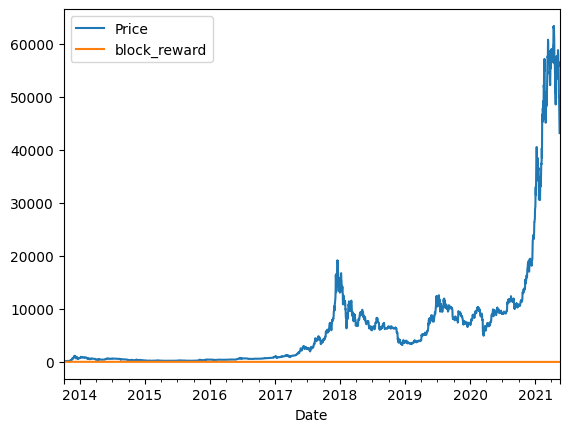

In [ ]:
bitcoin_prices_block.plot();

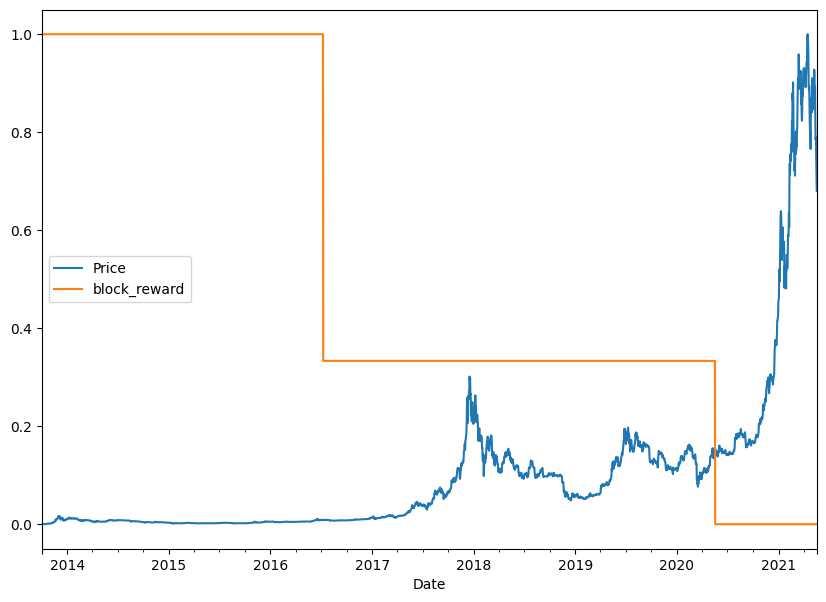

In [ ]:
# Plot the block reward vs price oveer time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                   columns=bitcoin_prices_block.columns,
                                                   index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.


In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset
directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X(windows) and y(horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense(multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_6.fit(X_train,y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 14s - loss: 6304.5664

18/18 [==============================] - 1s 35ms/step - loss: 4141.9697 - val_loss: 15512.6533
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 1905.2765

18/18 [==============================] - 0s 28ms/step - loss: 1103.5782 - val_loss: 3041.7339
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 437.9194

18/18 [==============================] - 0s 28ms/step - loss: 404.9344 - val_loss: 2006.1479
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 339.6054

18/18 [==============================] - 0s 27ms/step - loss: 248.8814 - val_loss: 1257.9094
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 218.9416

18/18 [==============================] - 0s 27ms/step - loss: 227.0521 - val_loss: 1230.3241
Epoch 6/100
13/18 [====================>.........] - ETA: 0s - loss: 215.4353

18/18 [==============================] - 0s 28ms/step - loss: 220.5626 - val_loss: 1214.5554
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 263.4292

18/18 [==============================] - 0s 28ms/step - loss: 218.3395 - val_loss: 1192.3457
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 202.4907

18/18 [==============================] - 0s 27ms/step - loss: 212.1052 - val_loss: 1189.5255
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 168.4254

18/18 [==============================] - 0s 27ms/step - loss: 207.4031 - val_loss: 1161.6207
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 227.5027

18/18 [==============================] - 1s 30ms/step - loss: 203.4211 - val_loss: 1106.4343
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 197.1315

18/18 [==============================] - 1s 41ms/step - loss: 196.5507 - val_loss: 1082.7719
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 194.4352 - val_loss: 1084.2748
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 189.5276 - val_loss: 1089.1779
Epoch 14/100
16/18 [=========================>....] - ETA: 0s - loss: 181.9808

18/18 [==============================] - 1s 33ms/step - loss: 185.5749 - val_loss: 1074.1138
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 184.3840

18/18 [==============================] - 0s 27ms/step - loss: 184.3840 - val_loss: 1016.0856
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 181.7846

18/18 [==============================] - 0s 27ms/step - loss: 177.2023 - val_loss: 988.6007
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 174.0317 - val_loss: 1042.7504
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 172.1865 - val_loss: 991.5800
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 167.6973 - val_loss: 993.4830
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 171.2700

18/18 [==============================] - 0s 26ms/step - loss: 164.1677 - val_loss: 916.8357
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 238.3982

18/18 [==============================] - 0s 28ms/step - loss: 160.6027 - val_loss: 890.5096
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 206.4943

18/18 [==============================] - 1s 45ms/step - loss: 155.5536 - val_loss: 877.6514
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 175.8605

18/18 [==============================] - 0s 27ms/step - loss: 151.5173 - val_loss: 844.6111
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 149.5425 - val_loss: 854.4355
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 148.4722

18/18 [==============================] - 0s 27ms/step - loss: 145.6982 - val_loss: 838.4135
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 141.3384

18/18 [==============================] - 0s 28ms/step - loss: 141.6146 - val_loss: 783.7371
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 202.8133

18/18 [==============================] - 0s 27ms/step - loss: 139.2417 - val_loss: 767.4973
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 138.6750

18/18 [==============================] - 1s 31ms/step - loss: 136.3477 - val_loss: 752.3478
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 131.8129

18/18 [==============================] - 1s 31ms/step - loss: 132.9836 - val_loss: 728.0699
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 133.1836 - val_loss: 831.1293
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 139.8828 - val_loss: 897.4418
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 143.1098

18/18 [==============================] - 0s 28ms/step - loss: 140.2298 - val_loss: 706.1432
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 157.1163

18/18 [==============================] - 0s 29ms/step - loss: 134.3033 - val_loss: 699.8283
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 133.4083

18/18 [==============================] - 1s 29ms/step - loss: 126.6777 - val_loss: 693.5828
Epoch 35/100
18/18 [==============================] - 0s 4ms/step - loss: 124.0750 - val_loss: 699.3984
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 126.5110 - val_loss: 760.4244
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 166.4382

18/18 [==============================] - 0s 28ms/step - loss: 124.8036 - val_loss: 681.4215
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 117.5857

18/18 [==============================] - 0s 28ms/step - loss: 121.3313 - val_loss: 658.4030
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 122.2920 - val_loss: 699.6145
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 119.7574

18/18 [==============================] - 0s 28ms/step - loss: 119.7574 - val_loss: 656.2186
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 114.3081

18/18 [==============================] - 1s 31ms/step - loss: 119.2685 - val_loss: 644.7198
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 122.8320 - val_loss: 645.2045
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 117.3509 - val_loss: 664.0801
Epoch 44/100
18/18 [==============================] - 0s 7ms/step - loss: 119.3979 - val_loss: 647.7419
Epoch 45/100
15/18 [========================>.....] - ETA: 0s - loss: 116.9746

18/18 [==============================] - 1s 41ms/step - loss: 119.3069 - val_loss: 643.9603
Epoch 46/100
14/18 [======================>.......] - ETA: 0s - loss: 119.1441

18/18 [==============================] - 1s 31ms/step - loss: 116.0916 - val_loss: 632.3882
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 117.8989 - val_loss: 769.1290
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 117.6978 - val_loss: 681.0171
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 172.7382

18/18 [==============================] - 0s 27ms/step - loss: 118.0833 - val_loss: 619.6907
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 112.9941 - val_loss: 625.1713
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 113.3635 - val_loss: 653.8142
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8243 - val_loss: 624.3376
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 114.9893 - val_loss: 643.5984
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 115.6886 - val_loss: 676.9056
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 118.1351 - val_loss: 642.3409
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 120.1275 - val_loss: 795.2619
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 118.2965

18/18 [==============================] - 0s 29ms/step - loss: 136.5039 - val_loss: 619.1953
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 116.6246 - val_loss: 651.0331
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 81.4912

18/18 [==============================] - 0s 27ms/step - loss: 110.5845 - val_loss: 600.6445
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6750 - val_loss: 625.4782
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 110.9502 - val_loss: 603.0392
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 76.9412

18/18 [==============================] - 0s 28ms/step - loss: 109.2555 - val_loss: 593.2616
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5856 - val_loss: 635.8242
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6333 - val_loss: 728.3757
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 118.0515 - val_loss: 614.2198
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 118.0905

18/18 [==============================] - 1s 47ms/step - loss: 112.7318 - val_loss: 592.5593
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9430 - val_loss: 621.1367
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 115.3047 - val_loss: 697.7958
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 126.8494 - val_loss: 725.0550
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 137.5860

18/18 [==============================] - 0s 28ms/step - loss: 120.8027 - val_loss: 590.6334
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 111.6058 - val_loss: 633.8857
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5074 - val_loss: 605.2460
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6861 - val_loss: 614.7199
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 169.3513

18/18 [==============================] - 0s 27ms/step - loss: 108.9993 - val_loss: 588.6325
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 110.4258 - val_loss: 630.8100
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 82.8853

18/18 [==============================] - 0s 27ms/step - loss: 111.7334 - val_loss: 588.0737
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 82.5613

18/18 [==============================] - 0s 29ms/step - loss: 109.8292 - val_loss: 582.5576
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 109.5112

18/18 [==============================] - 0s 27ms/step - loss: 107.9288 - val_loss: 580.7072
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 107.4985 - val_loss: 596.4553
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4424 - val_loss: 599.7595
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 97.6308

18/18 [==============================] - 0s 28ms/step - loss: 107.8536 - val_loss: 578.3847
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 196.1588

18/18 [==============================] - 0s 27ms/step - loss: 114.8050 - val_loss: 577.7493
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3787 - val_loss: 658.6110
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6767 - val_loss: 580.7023
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7308 - val_loss: 610.8040
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 109.6579 - val_loss: 610.5522
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 123.7234

18/18 [==============================] - 0s 28ms/step - loss: 107.8649 - val_loss: 574.6611
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 107.5711 - val_loss: 597.0222
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1579 - val_loss: 575.1991
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8251 - val_loss: 640.2558
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 113.1974 - val_loss: 627.7695
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1651 - val_loss: 576.6196
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 114.2384 - val_loss: 620.8754
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 109.5741 - val_loss: 581.8917
Epoch 95/100
18/18 [==============================] - 0s 7ms/step - loss: 106.0662 - val_loss: 580.9801
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 11

18/18 [==============================] - 1s 40ms/step - loss: 108.8568 - val_loss: 572.6661
Epoch 99/100
18/18 [==============================] - 0s 7ms/step - loss: 107.2591 - val_loss: 572.9937
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 113.1307 - val_loss: 645.1162


In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 645.1163


645.1163330078125

In [ ]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 572.6663


572.666259765625

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8877.206, 8790.087, 9021.403, 8773.978, 8752.374, 8743.45 ,
       8684.857, 8508.84 , 8480.066, 8516.435], dtype=float32)>

In [ ]:
# Evaluate predictions to get evaluate metrics
model_6_results= evaluate_preds(y_true=y_test,
                                y_pred=model_6_preds)

model_6_results

{'mae': 572.66626,
 'mape': 2.5585918,
 'mase': 1.006016,
 'mse': 1182314.5,
 'rmse': 1087.3428}

In [ ]:
model_1_results

{'mae': 572.9511,
 'mape': 2.5751002,
 'mase': 1.0065165,
 'mse': 1188773.8,
 'rmse': 1090.309}

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest(though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results


### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
# Create NBEATBLOCK custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): #the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
      super().__init__(**kwargs)
      self.input_size = input_size
      self.theta_size = theta_size
      self.horizon = horizon
      self.n_neurons = n_neurons
      self.n_layers = n_layers

      # Block contains stacks of 4 fully connected layers each has ReLU activation
      self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
      # Output of block is a theta layer with linear activation
      self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x =  layer(x)
    theta = self.theta_layer(x)
    # output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [ ]:
# Set up Dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size= WINDOW_SIZE,
                                       theta_size= WINDOW_SIZE +HORIZON, #backcast, forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements(n_dim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.4963022   0.32465425 -0.6840944   0.1177332  -0.87275356  0.66357183
 -0.3093449 ]
Forecast: -0.3412698209285736


## Preparing data for the N-BEATS algorithm using `tf.data`
To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+ {i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+ 1,Price+ 2,Price+ 3,Price+ 4,Price+ 5,Price+ 6,Price+ 7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# MAke train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)


(2224, 2224, 556, 556)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm
The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections
Before we can craft out N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Substract
substracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1 , tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {substracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of the stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts.
6. Create the double residual stacking using subtract and add layers.
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss(the paper uses multiple losses but we'll use MAE to keep it inline with other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper.
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
 * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
 * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 239: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 339: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 47s, sys: 2.18 s, total: 1min 49s
Wall time: 2min 9s


In [ ]:
# Evaluate N-Beats on test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 24ms/step - loss: 572.8086 - mae: 572.8086 - mse: 1185494.8750


[572.80859375, 572.80859375, 1185494.875]

In [ ]:
# Make predictions with N-Beats model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8902.479, 8854.508, 8975.01 , 8760.503, 8784.016, 8735.294,
       8648.891, 8523.285, 8505.223, 8486.332], dtype=float32)>

In [ ]:
# Evaluate N-Beats model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 572.8086,
 'mape': 2.6567538,
 'mase': 1.006266,
 'mse': 1185494.9,
 'rmse': 1088.8043}

In [ ]:
model_1_results

{'mae': 572.9511,
 'mape': 2.5751002,
 'mase': 1.0065165,
 'mse': 1188773.8,
 'rmse': 1090.309}

### Plotting the N-BEATS architecture we've created

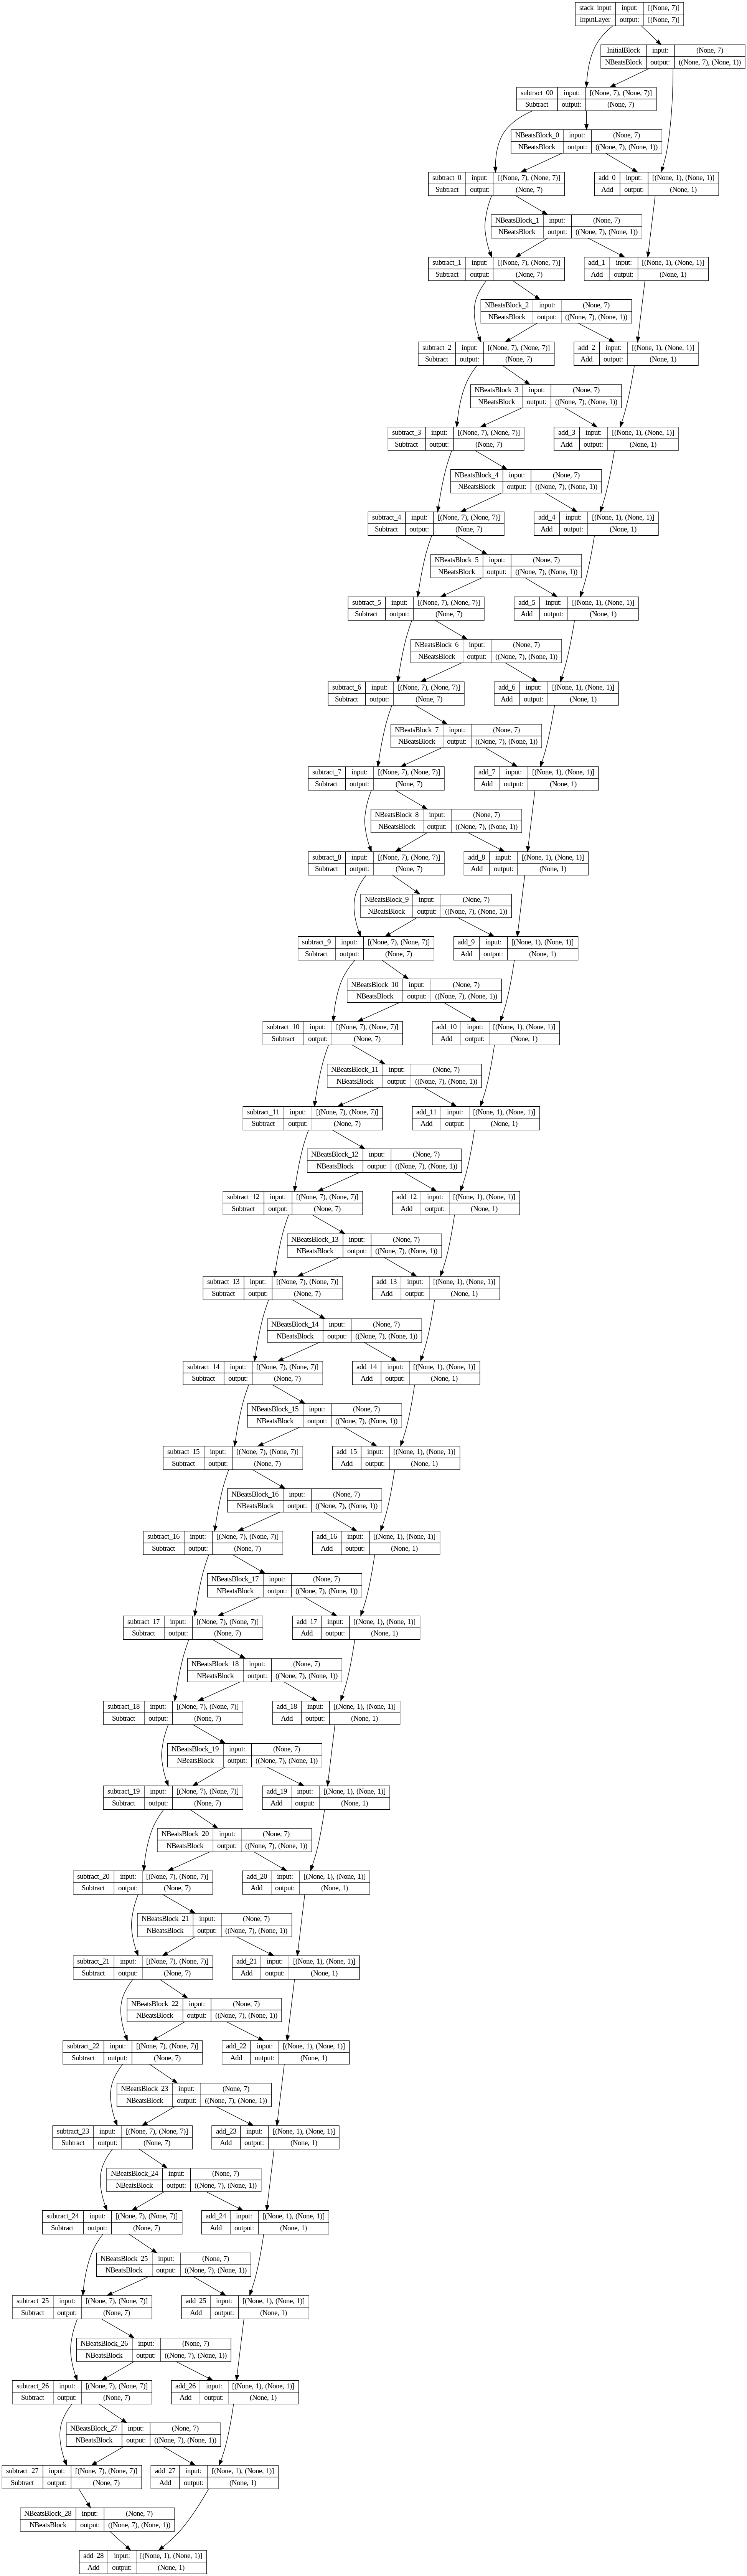

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_7,show_shapes=True,to_file="model.png" )

## Model 8: Creating an ensemble(stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting and ensemble of models(using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initializer dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal" ,activation ="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])


      # compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # fit the currrent model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models


In [ ]:
%%time
# Get list of trained ensemble models
ensemble_model = get_ensemble_models(num_iter=5,
                                     num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 475: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 972: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 215: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 315: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 193: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 444: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 544: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 334: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 758: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 858:

## Make prediction with our ensemble models

In [ ]:
len(ensemble_model)

15

In [ ]:
ensemble_model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_model,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step
CPU times: user 634 ms, sys: 26.9 ms, total: 661 ms
Wall time: 777 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8788.304 ,  8785.871 ,  9065.9795, ..., 50010.566 , 48950.18  ,
        45408.473 ],
       [ 8739.17  ,  8779.68  ,  9045.408 , ..., 50436.37  , 48232.61  ,
        46940.85  ],
       [ 8788.625 ,  8770.271 ,  9084.142 , ..., 50121.902 , 48255.742 ,
        45926.723 ],
       ...,
       [ 8845.149 ,  8826.42  ,  9152.688 , ..., 49931.27  , 47965.062 ,
        45416.953 ],
       [ 8742.998 ,  8775.864 ,  9028.476 , ..., 49830.992 , 47928.05  ,
        45661.477 ],
       [ 8757.283 ,  8704.914 ,  9037.749 , ..., 49565.742 , 48606.5   ,
        45626.152 ]], dtype=float32)>

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)

ensemble_results

{'mae': 576.2603,
 'mape': 2.6302278,
 'mase': 1.0123297,
 'mse': 1168062.8,
 'rmse': 1080.7374}

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8784.782, 8770.006, 9064.464, 8703.376, 8730.259, 8733.476,
       8667.591, 8472.777, 8452.167, 8526.812], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8780.969 , 8776.786 , 9065.9795, 8701.606 , 8730.09  , 8733.44  ,
       8671.317 , 8471.352 , 8448.927 , 8524.222 ], dtype=float32)

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 567.0865,
 'mape': 2.5720086,
 'mase': 0.9962139,
 'mse': 1138045.2,
 'rmse': 1066.792}

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 567.2422,
 'mape': 2.5683815,
 'mase': 0.99648744,
 'mse': 1139218.4,
 'rmse': 1067.3417}

### Plotting the prediction intervals (uncertainity estimates) of our ensemble

So far we've been making point predictions with our model.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussain/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in (1)


In [ ]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): #1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply ultiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the predictions interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper


In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[:10], upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8722.412 , 8702.189 , 9002.517 , 8654.256 , 8678.4375, 8654.684 ,
        8606.247 , 8414.91  , 8403.129 , 8485.77  ], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8847.152, 8837.822, 9126.411, 8752.496, 8782.08 , 8812.268,
        8728.935, 8530.645, 8501.205, 8567.854], dtype=float32)>)

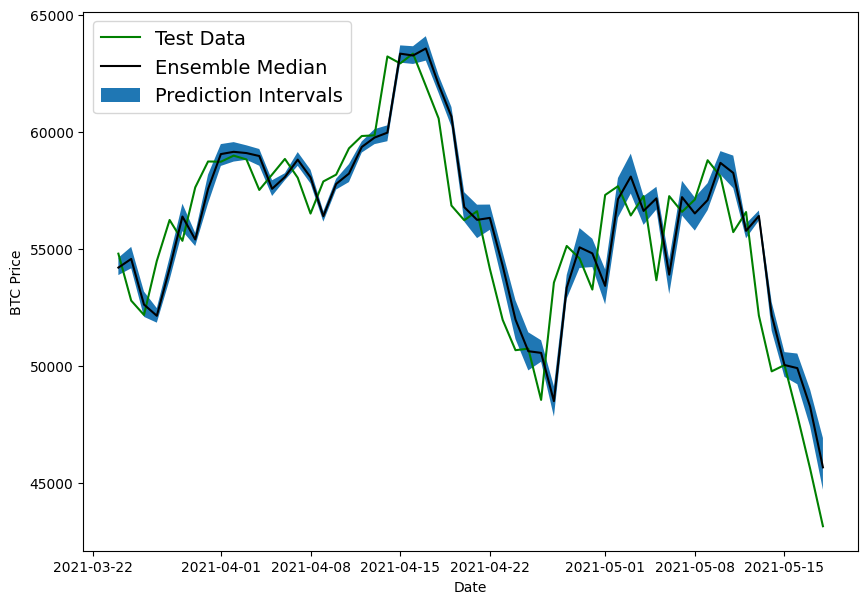

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median =  np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction interval (where the prediction fall between)
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between of matplotlib
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Aside: two types of uncertainty (coconut and subway)
Inheritly, you know you cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a **point prediction**, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as we've discussed knowing a **prediction interval** or **uncertainty estimate** can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

* What can my model know? (with perfect data, what's possible to learn?)
* What doesn't my model know? (what can a model never predict?)

There are two types of uncertainty in machine learning you should be aware of:

* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

 * Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).

 * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

 * The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.

    * If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?

    * But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
 * Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.

The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

## Model 9: Train a model on the full historical data to make predictions into the future

So, far all models have predicted on the test dataset, however, this is only a pesudofuture.

Let's now build a model which is capable of predicting into the future!

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
# Turn data into efficent running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit the model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions into future

In [ ]:
# How many timesteps to predict in the future?
INTO_FUTURE = 14

To make predictions into the future we want to function which:

1. Takes as input:
 * a list of values (Bitcoin historical data)
 * a trained model (such as `model_9`)
 * a window into the future to predict(our `INTO_FUTURE` variable)
 * the window size a model was trained on(`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on.
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full on predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again(model will eventually start to make forecast on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds(model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 18ms/step
Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55250.77734375

1/1 [==============================] - 0s 18ms/step
Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55250.77734375] -> Prediction: 52105.2578125

1/1 [==============================] - 0s 17ms/step
Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55250.77734375 52105.2578125 ] -> Prediction: 48812.578125

1/1 [==============================] - 0s 17ms/step
Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55250.77734375 52105.2578125  48812.578125  ] -> Prediction: 47440.99609375

1/1 [==============================] - 0s 18ms/step
Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 55250.77734375
 52105.2578125  48812.578125   47440.99609375]

In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


### Plot future forecast

In [ ]:
future_forecast

[55250.777,
 52105.258,
 48812.58,
 47440.996,
 46033.586,
 47909.383,
 46622.11,
 53840.53,
 50708.63,
 47332.65,
 46392.28,
 46047.277,
 49665.504,
 48596.547]

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") #return a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
# Insert last timestep/final price into next time step and future forecast so the plot looks prettier
next_time_steps = np.insert(next_time_steps, 0, last_tumestep)


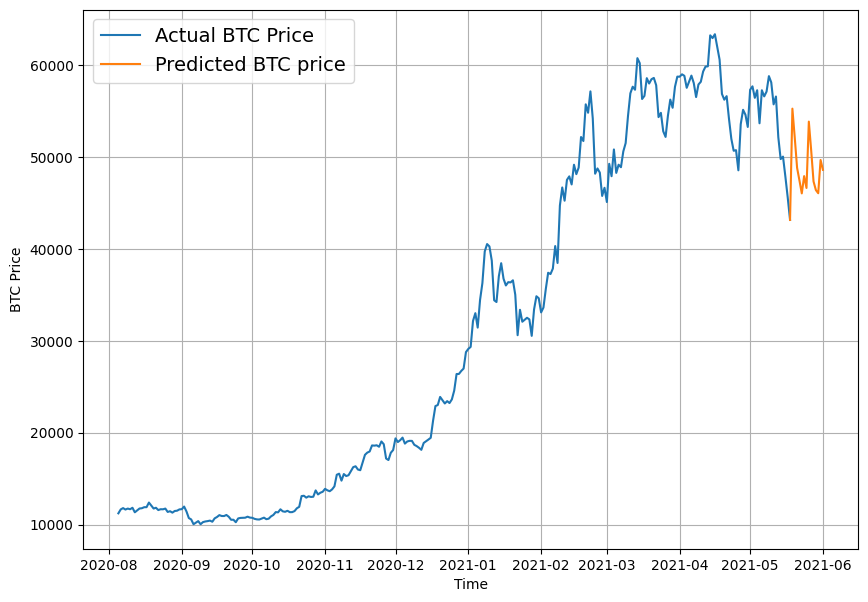

In [ ]:
# Plot future prices prediction of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC price")